In [1]:
import pickle
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, f1_score
import numpy as np
import copy
from tqdm import tqdm
import gensim.downloader as api
# from sqlalchemy import create_engine

import random
random.seed(42)
np.random.seed(42)

In [7]:
import os
os.getenv('MLFLOW_S3_ENDPOINT_URL', None)

In [8]:
os.getenv('MLFLOW_TRACKING_URI', None)

In [9]:
import mlflow
from mlflow.models import infer_signature

# Задача

Задача проекта и наличие только текстовых данных предполагает использование именно DL модели, и свести изначальную задачу к ML-задаче не получилось. Поэтому в данной части весь пайплайн отрабатывается на искусственной задаче, которую мы поставили исходя из имеющихся данных.

**Задача:** по текстовым данным, характеризующим субъет и объект, определить, какой предикат используется для связи этих сущностей. <br>
*Например: для субъекта "man" и объекта "car" предсказать предикат "in".*

Соотвтетсвенно поставлена задача *многоклассовой классификации*. Так как вохможных предикатов много, были отобраны 10 наиболее частых, а тренировочная и тестовые выборки были составлены таким образом, что классы оказались сбалансированы.

Замечание: мы предполагаем низкое качество моделей, так как задача искусственная, наша цель - отработать сам механизм и получше изучить данные.

# Данные

In [2]:
url = 'https://drive.google.com/file/d/1maREFJtWyLawpbhLzwy0v9ST2Zh4pnST/view?usp=drive_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
X_train = pd.read_pickle(path)

url = 'https://drive.google.com/file/d/1fomEPFybQvi0Z5akl98YamiXytZ3RwuV/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
X_test = pd.read_pickle(path)

url = 'https://drive.google.com/file/d/10A7FhzHV9mQDkKCaGMa0viWYSBwMn4FT/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
y_train = pd.read_pickle(path)

url = 'https://drive.google.com/file/d/13LyPwgj0gPXhIWG-XyPeMRhu6IY0n4Dr/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
y_test = pd.read_pickle(path)

In [3]:
X_train.head(5)

objects  subjects
21203  pizza cutter      hand
31200          tree  branches
31841          dots       tie
6707            hat       boy
21703        ground     weeds

In [4]:
y_train.head(5)

21203         on
31200     behind
31841        has
6707     wearing
21703         of
dtype: object

# План

Будут протестированы следующие модели классификации:
 - LogisticRegression
 - SVC
 - RandomForestClassifier
 - CatBoostClassifier
 
А аткже способы векторизации:
- CountVectorizer
- ~~TfIdfVectorizer~~ (не использовали, потому что метрика теряет смысл в отсутствии других слов в документе (words per document))

и эмбеддинги: 
- word2vec-google-news-300
- fasttext-wiki-news-subwords-300
- glove-wiki-gigaword-100
- glove-wiki-gigaword-300.

Для каждого способа векторизации будут обучены  все вышеперечисленные модели с дефолтными (или близкими к дефолтным и необходимыми для сходимости) гиперпараметрами.
Далее, будет выбрана модель, показавшая наилучшее качество, и дальнейшая работа будет проделана уже только с ней. 

## MLFlow

Пока эксперименты не были запущены и метрики не сохранены, но мы оставили здесь кодовую часть для реализации трекинга метрик и сохранения модели на будущее.

In [10]:
from sklearn.metrics import accuracy_score, f1_score
def train_model(model, model_name, X_train, X_test, y_train, y_test) -> None:

    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    macro_f1 = f1_score(y_test, predictions, average='macro')

    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('macro_f1', macro_f1)

    signature = infer_signature(X_test, predictions)
    mlflow.sklearn.log_model(model, f'{model_name}', signature=signature)
    mlflow.sklearn.save_model(model, f'{model_name}')

In [ ]:
exp_name = 'project_ml'
mlflow.create_experiment(exp_name, artifact_location=f's3://kirill-rubashevskiy-mlflow/{exp_name}')
mlflow.set_experiment(exp_name)

# CountVectorizer

Важно, что векторайзеры обучаются на обоих столбцах (shared vocab). Для CountVectorizer это не важно, а для TF-IDF - очень.

In [3]:
def fit_vec(df: pd.DataFrame, vectorizer):
    """Обучает векторайзер на обоих признаках (objects, subjects) и возвращает обученный векторайзер"""
    
    df0=df.loc[:,'objects']
    df1=df.loc[:,'subjects']
    res = pd.concat([df0,df1],axis=0).reset_index(drop=True)

    fitted_vec = vectorizer.fit(res)
    return fitted_vec

In [4]:
cv = fit_vec(X_train, CountVectorizer())

# векторизация трейна
X_train_cv_objects = pd.DataFrame(cv.transform(X_train['objects']).todense())
X_train_cv_subjects = pd.DataFrame(cv.transform(X_train['subjects']).todense())

X_train_cv = pd.concat([X_train_cv_objects, X_train_cv_subjects], axis=1).reset_index(drop=True)
X_train_cv.columns = range(X_train_cv.columns.size)

# векторизация теста
X_test_cv_objects = pd.DataFrame(cv.transform(X_test['objects']).todense())
X_test_cv_subjects = pd.DataFrame(cv.transform(X_test['subjects']).todense())

X_test_cv = pd.concat([X_test_cv_objects, X_test_cv_subjects], axis=1).reset_index(drop=True)
X_test_cv.columns = range(X_test_cv.columns.size)

## Logistic Regression

In [22]:
lr = LogisticRegression(max_iter=1000)

lr.fit(X_train_cv, y_train)

LogisticRegression(max_iter=1000)

In [13]:
print(classification_report(y_train, lr.predict(X_train_cv)))

              precision    recall  f1-score   support

      behind       0.40      0.38      0.39      3969
         has       0.39      0.36      0.38      3969
     holding       0.40      0.44      0.42      3968
          in       0.41      0.34      0.37      3968
        near       0.41      0.42      0.41      3968
          of       0.40      0.39      0.39      3969
          on       0.40      0.31      0.35      3968
   on top of       0.44      0.54      0.48      3968
     wearing       0.34      0.51      0.41      3969
        with       0.44      0.30      0.36      3968

    accuracy                           0.40     39684
   macro avg       0.40      0.40      0.40     39684
weighted avg       0.40      0.40      0.40     39684



In [14]:
print(classification_report(y_test, lr.predict(X_test_cv)))

              precision    recall  f1-score   support

      behind       0.30      0.28      0.29      1954
         has       0.25      0.23      0.24      1954
     holding       0.31      0.33      0.32      1955
          in       0.27      0.22      0.24      1955
        near       0.29      0.31      0.30      1955
          of       0.26      0.26      0.26      1954
          on       0.21      0.16      0.18      1955
   on top of       0.32      0.40      0.36      1955
     wearing       0.28      0.40      0.33      1954
        with       0.19      0.14      0.16      1955

    accuracy                           0.27     19546
   macro avg       0.27      0.27      0.27     19546
weighted avg       0.27      0.27      0.27     19546



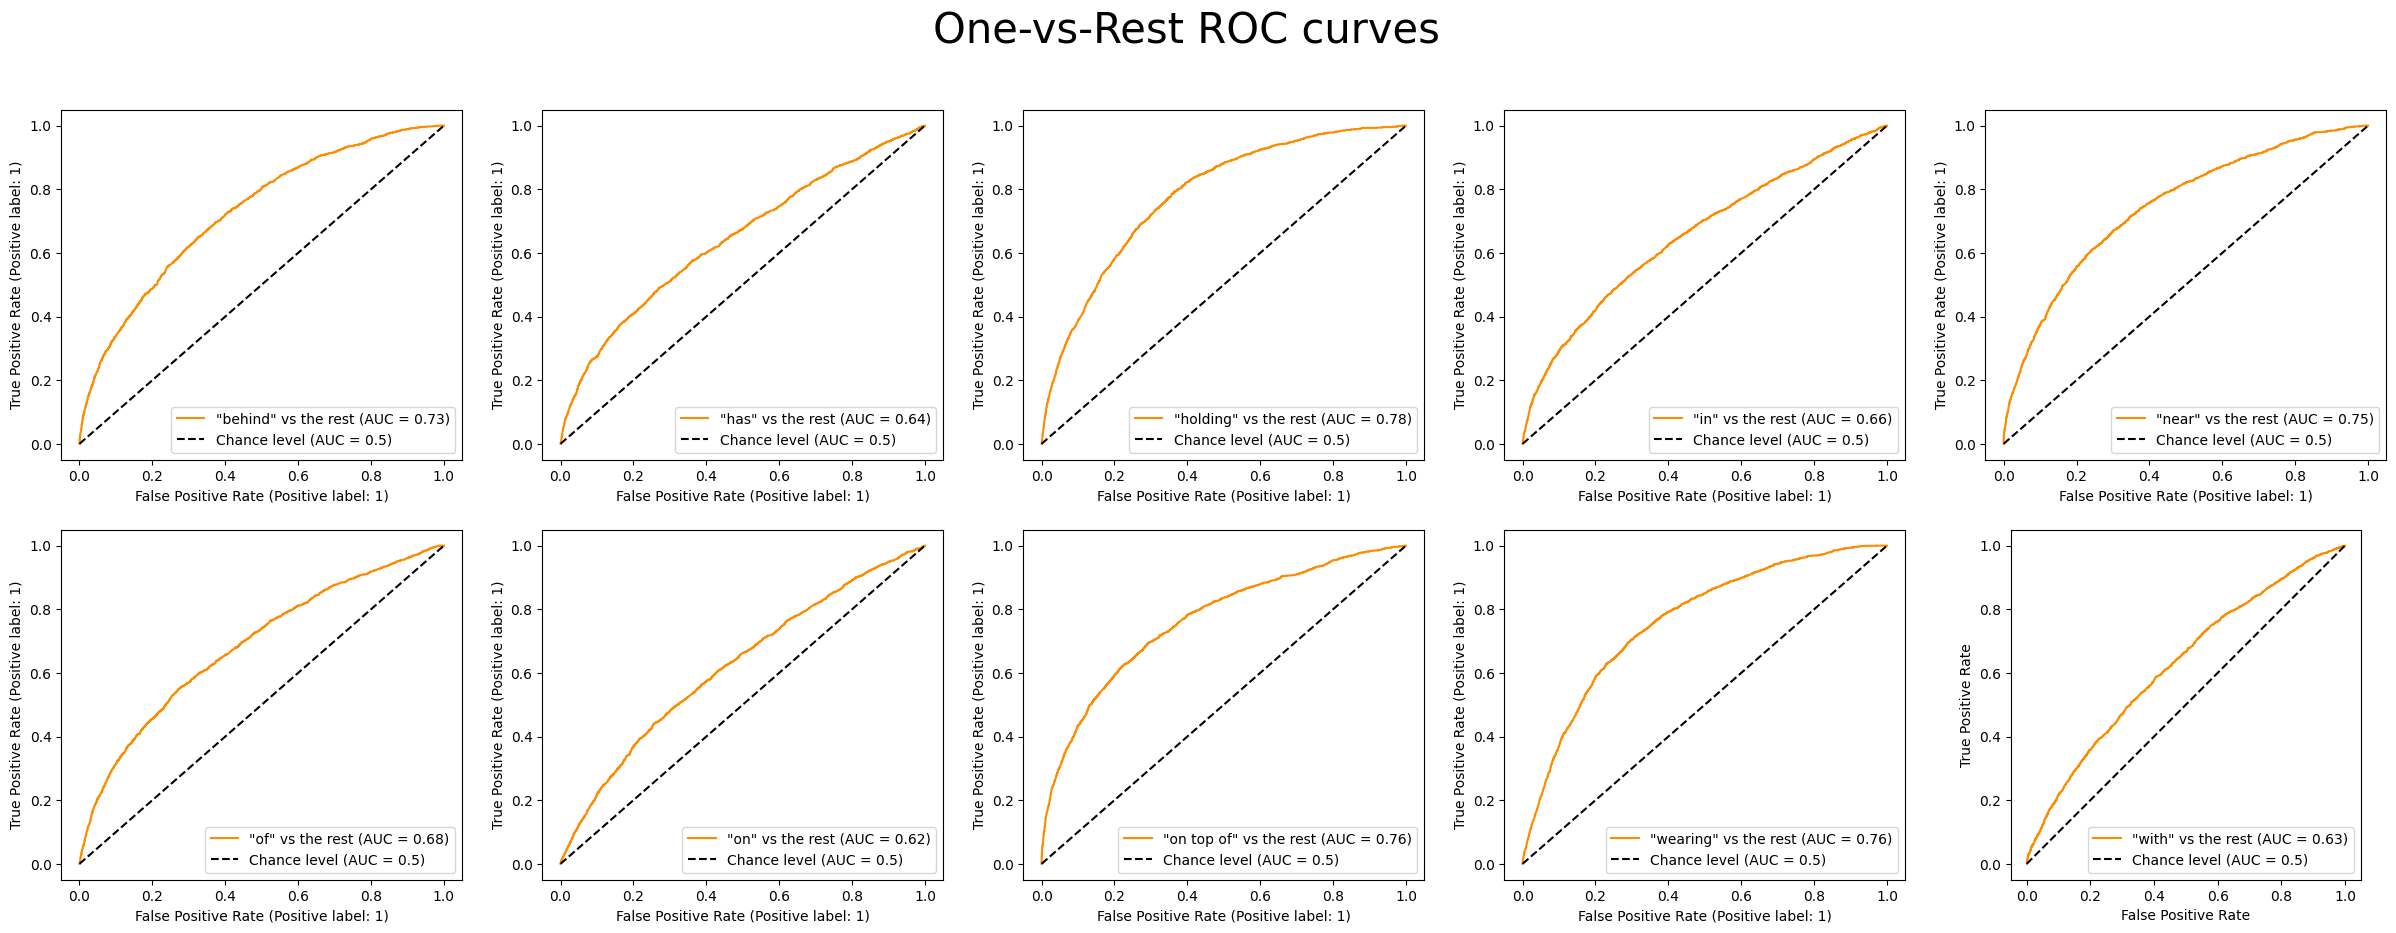

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import LabelBinarizer


label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(lr.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            lr.predict_proba(X_test_cv)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            lr.predict_proba(X_test_cv)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

## SVM

In [6]:
# ускорениене SVM

from sklearnex import patch_sklearn 
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [7]:
svc = SVC(max_iter=5000) # ограничение по итерацием поставлено для экономии времени, даже без ограничения, свм показывала сравнительно низкие результаты

svc.fit(X_train_cv, y_train)

In [ ]:
print(classification_report(y_train, svc.predict(X_train_cv)))

              precision    recall  f1-score   support

      behind       0.27      0.04      0.07      3969
         has       0.18      0.01      0.02      3969
     holding       0.24      0.05      0.09      3968
          in       0.15      0.02      0.03      3968
        near       0.23      0.09      0.13      3968
          of       0.18      0.10      0.13      3969
          on       0.14      0.11      0.12      3968
   on top of       0.14      0.15      0.14      3968
     wearing       0.14      0.36      0.20      3969
        with       0.11      0.43      0.18      3968

    accuracy                           0.14     39684
   macro avg       0.18      0.14      0.11     39684
weighted avg       0.18      0.14      0.11     39684



In [ ]:
print(classification_report(y_test, svc.predict(X_test_cv)))

In [ ]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(svc.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            svc.predict_proba(X_test_cv)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            svc.predict_proba(X_test_cv)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

## RandomForest

In [5]:
rf = RandomForestClassifier()
rf.fit(X_train_cv, y_train)

RandomForestClassifier()

In [8]:
print(classification_report(y_train, rf.predict(X_train_cv)))

              precision    recall  f1-score   support

      behind       0.66      0.67      0.66      3969
         has       0.66      0.61      0.63      3969
     holding       0.63      0.66      0.64      3968
          in       0.68      0.62      0.64      3968
        near       0.68      0.69      0.68      3968
          of       0.68      0.65      0.66      3969
          on       0.67      0.61      0.64      3968
   on top of       0.68      0.73      0.70      3968
     wearing       0.52      0.70      0.60      3969
        with       0.74      0.60      0.66      3968

    accuracy                           0.65     39684
   macro avg       0.66      0.65      0.65     39684
weighted avg       0.66      0.65      0.65     39684



In [9]:
print(classification_report(y_test, rf.predict(X_test_cv)))

              precision    recall  f1-score   support

      behind       0.36      0.34      0.35      1954
         has       0.24      0.21      0.23      1954
     holding       0.31      0.33      0.32      1955
          in       0.28      0.24      0.26      1955
        near       0.35      0.37      0.36      1955
          of       0.25      0.24      0.25      1954
          on       0.18      0.17      0.18      1955
   on top of       0.38      0.43      0.40      1955
     wearing       0.27      0.36      0.31      1954
        with       0.23      0.18      0.20      1955

    accuracy                           0.29     19546
   macro avg       0.28      0.29      0.28     19546
weighted avg       0.28      0.29      0.28     19546



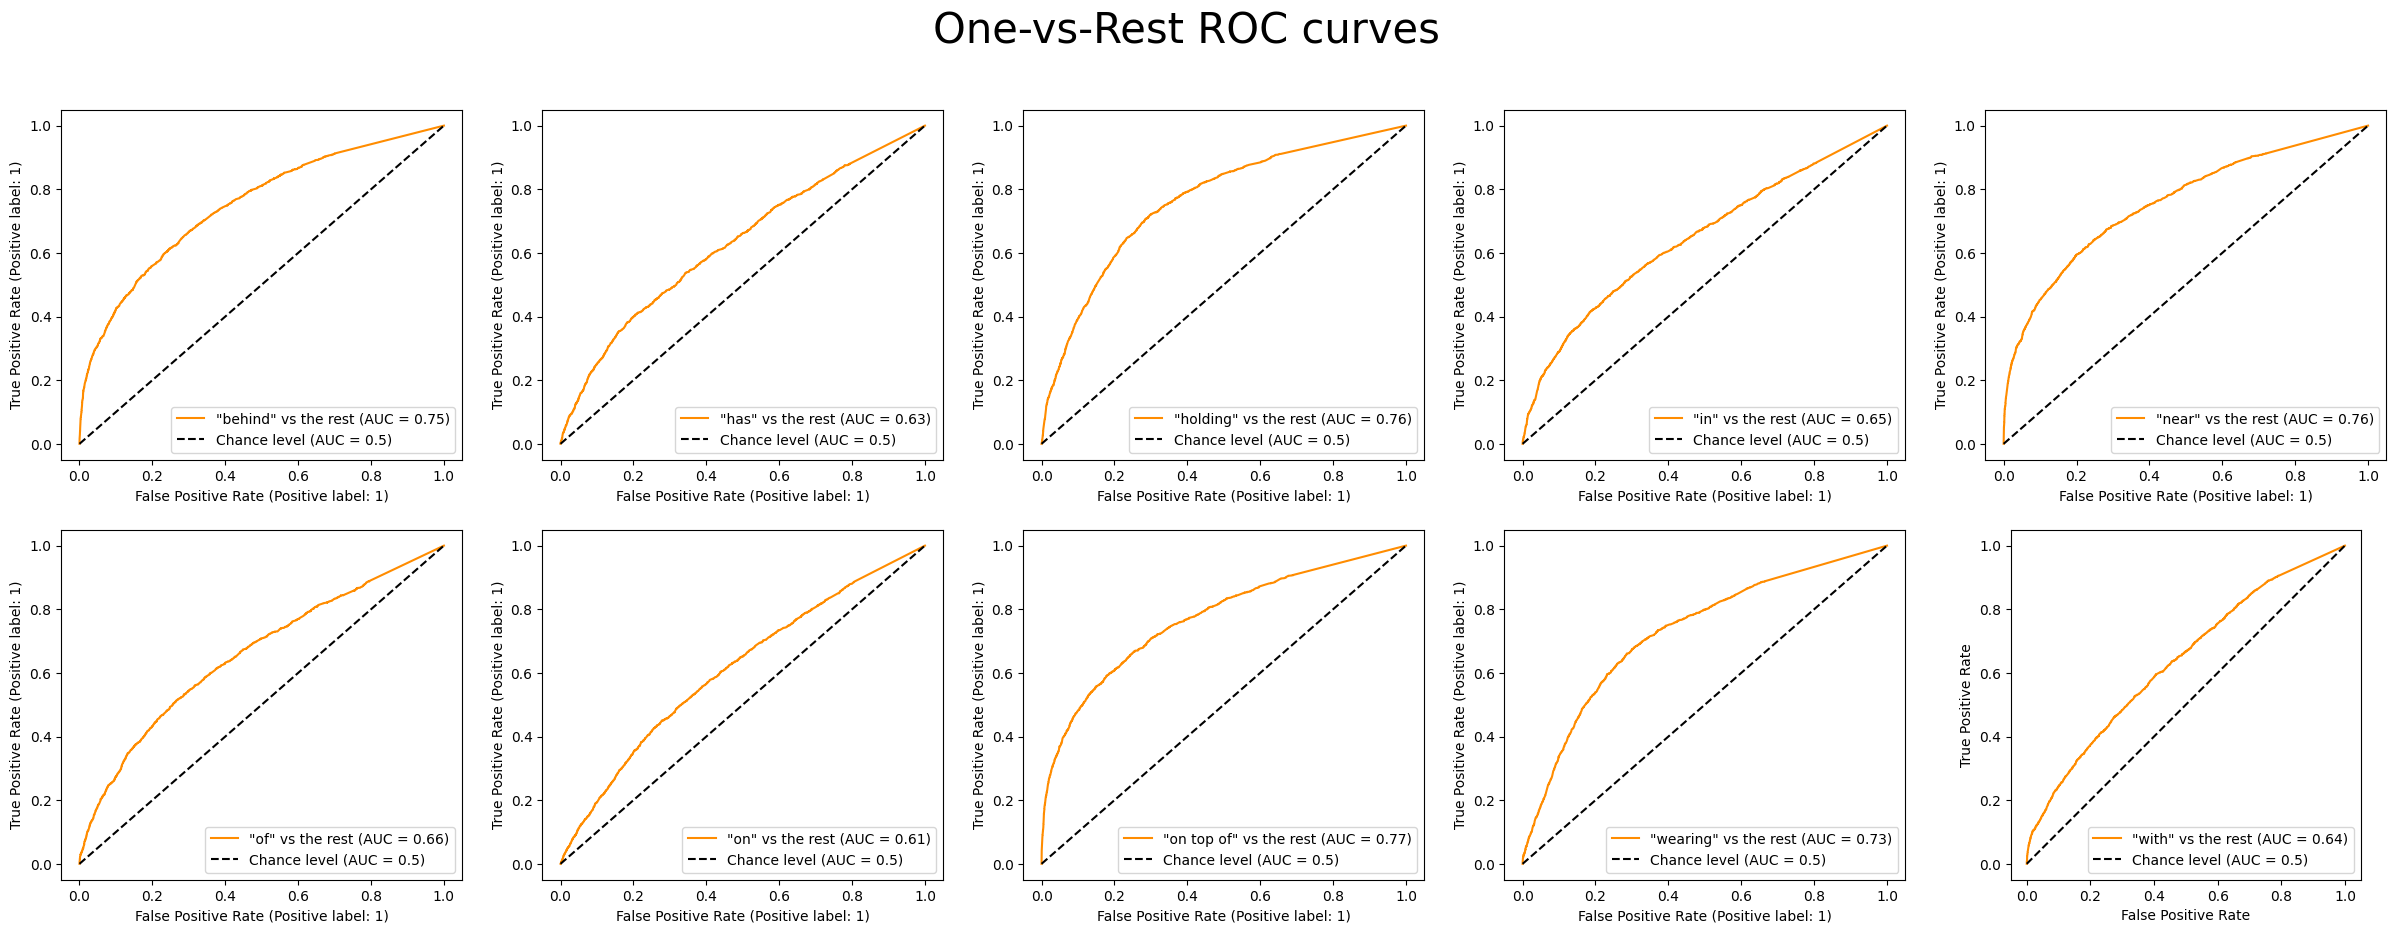

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(rf.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            rf.predict_proba(X_test_cv)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            rf.predict_proba(X_test_cv)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

## CatBoost

In [14]:
cb = CatBoostClassifier(verbose=500)

cb.fit(X_train_cv, y_train)

Learning rate set to 0.095467
0:	learn: 2.2936238	total: 32.1ms	remaining: 32.1s
500:	learn: 2.0945793	total: 19.1s	remaining: 19s
999:	learn: 2.0569471	total: 37.9s	remaining: 0us


In [15]:
print(classification_report(y_train, cb.predict(X_train_cv)))

              precision    recall  f1-score   support

      behind       0.35      0.29      0.32      3969
         has       0.29      0.24      0.27      3969
     holding       0.34      0.32      0.33      3968
          in       0.30      0.23      0.26      3968
        near       0.33      0.34      0.34      3968
          of       0.30      0.30      0.30      3969
          on       0.25      0.21      0.23      3968
   on top of       0.36      0.47      0.41      3968
     wearing       0.28      0.44      0.34      3969
        with       0.23      0.20      0.21      3968

    accuracy                           0.30     39684
   macro avg       0.30      0.30      0.30     39684
weighted avg       0.30      0.30      0.30     39684



In [16]:
print(classification_report(y_test, cb.predict(X_test_cv)))

              precision    recall  f1-score   support

      behind       0.31      0.26      0.28      1954
         has       0.24      0.20      0.22      1954
     holding       0.32      0.30      0.31      1955
          in       0.26      0.21      0.23      1955
        near       0.28      0.29      0.28      1955
          of       0.24      0.25      0.24      1954
          on       0.18      0.15      0.16      1955
   on top of       0.31      0.41      0.36      1955
     wearing       0.26      0.40      0.32      1954
        with       0.16      0.14      0.15      1955

    accuracy                           0.26     19546
   macro avg       0.26      0.26      0.25     19546
weighted avg       0.26      0.26      0.25     19546



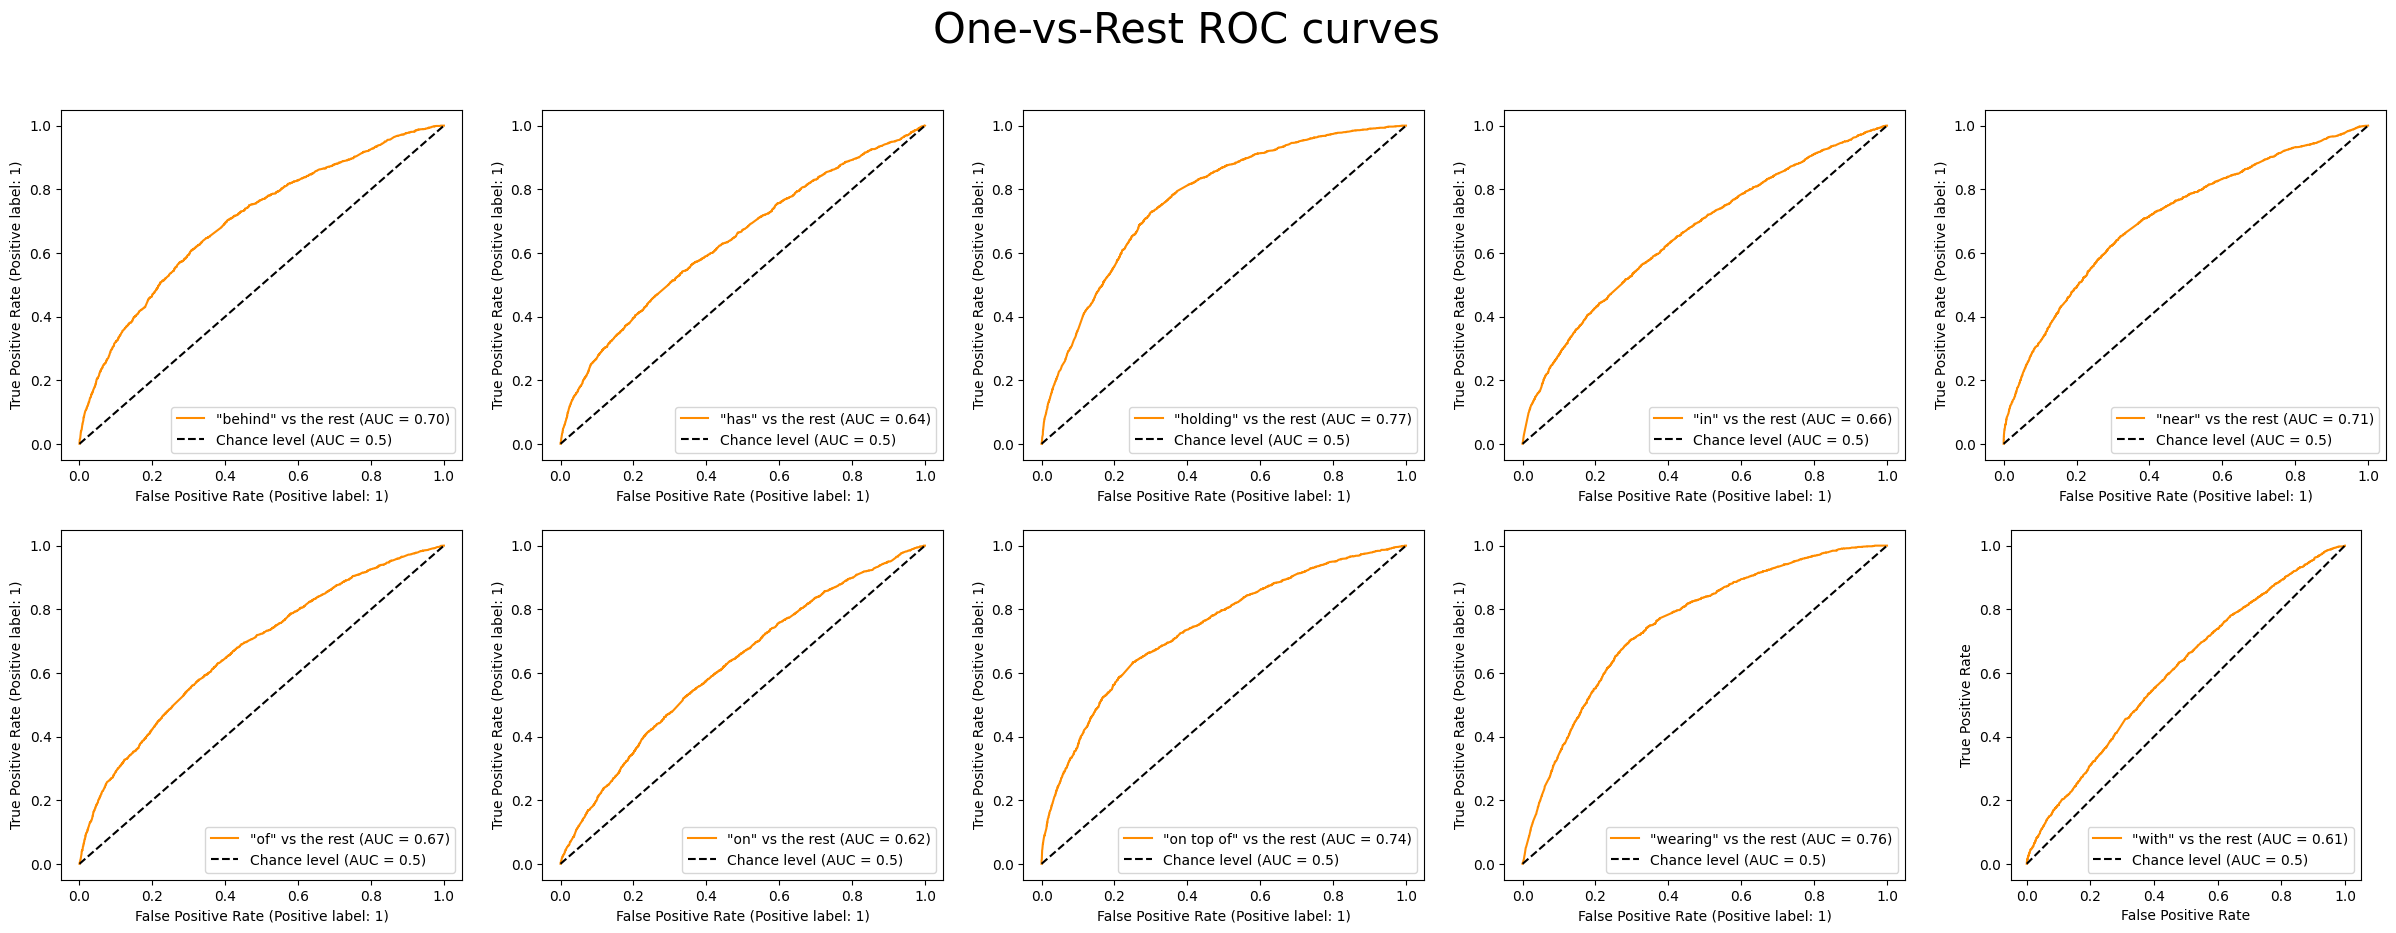

In [17]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(cb.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            cb.predict_proba(X_test_cv)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            cb.predict_proba(X_test_cv)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

# Embeddings

## word2vec-google-news-300

In [18]:
word_vectors = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [19]:
X_train_emb = pd.DataFrame()
X_train_emb['objects'] = X_train['objects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(300))
X_train_emb['subjects'] = X_train['subjects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(300))

objects = np.stack(X_train_emb['objects'].values, axis=0)
subjects = np.stack(X_train_emb['subjects'].values, axis=0)
X_train_emb = np.concatenate((objects, subjects), axis=1)

In [20]:
X_test_emb = pd.DataFrame()
X_test_emb['objects'] = X_test['objects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(300))
X_test_emb['subjects'] = X_test['subjects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(300))

objects = np.stack(X_test_emb['objects'].values, axis=0)
subjects = np.stack(X_test_emb['subjects'].values, axis=0)
X_test_emb = np.concatenate((objects, subjects), axis=1)

              precision    recall  f1-score   support

      behind       0.30      0.28      0.29      3969
         has       0.28      0.25      0.26      3969
     holding       0.30      0.39      0.34      3968
          in       0.29      0.24      0.27      3968
        near       0.30      0.32      0.31      3968
          of       0.30      0.28      0.29      3969
          on       0.24      0.16      0.20      3968
   on top of       0.32      0.44      0.37      3968
     wearing       0.29      0.40      0.33      3969
        with       0.28      0.17      0.21      3968

    accuracy                           0.29     39684
   macro avg       0.29      0.29      0.29     39684
weighted avg       0.29      0.29      0.29     39684

              precision    recall  f1-score   support

      behind       0.25      0.24      0.25      1954
         has       0.24      0.21      0.23      1954
     holding       0.28      0.36      0.31      1955
          in       0.26 

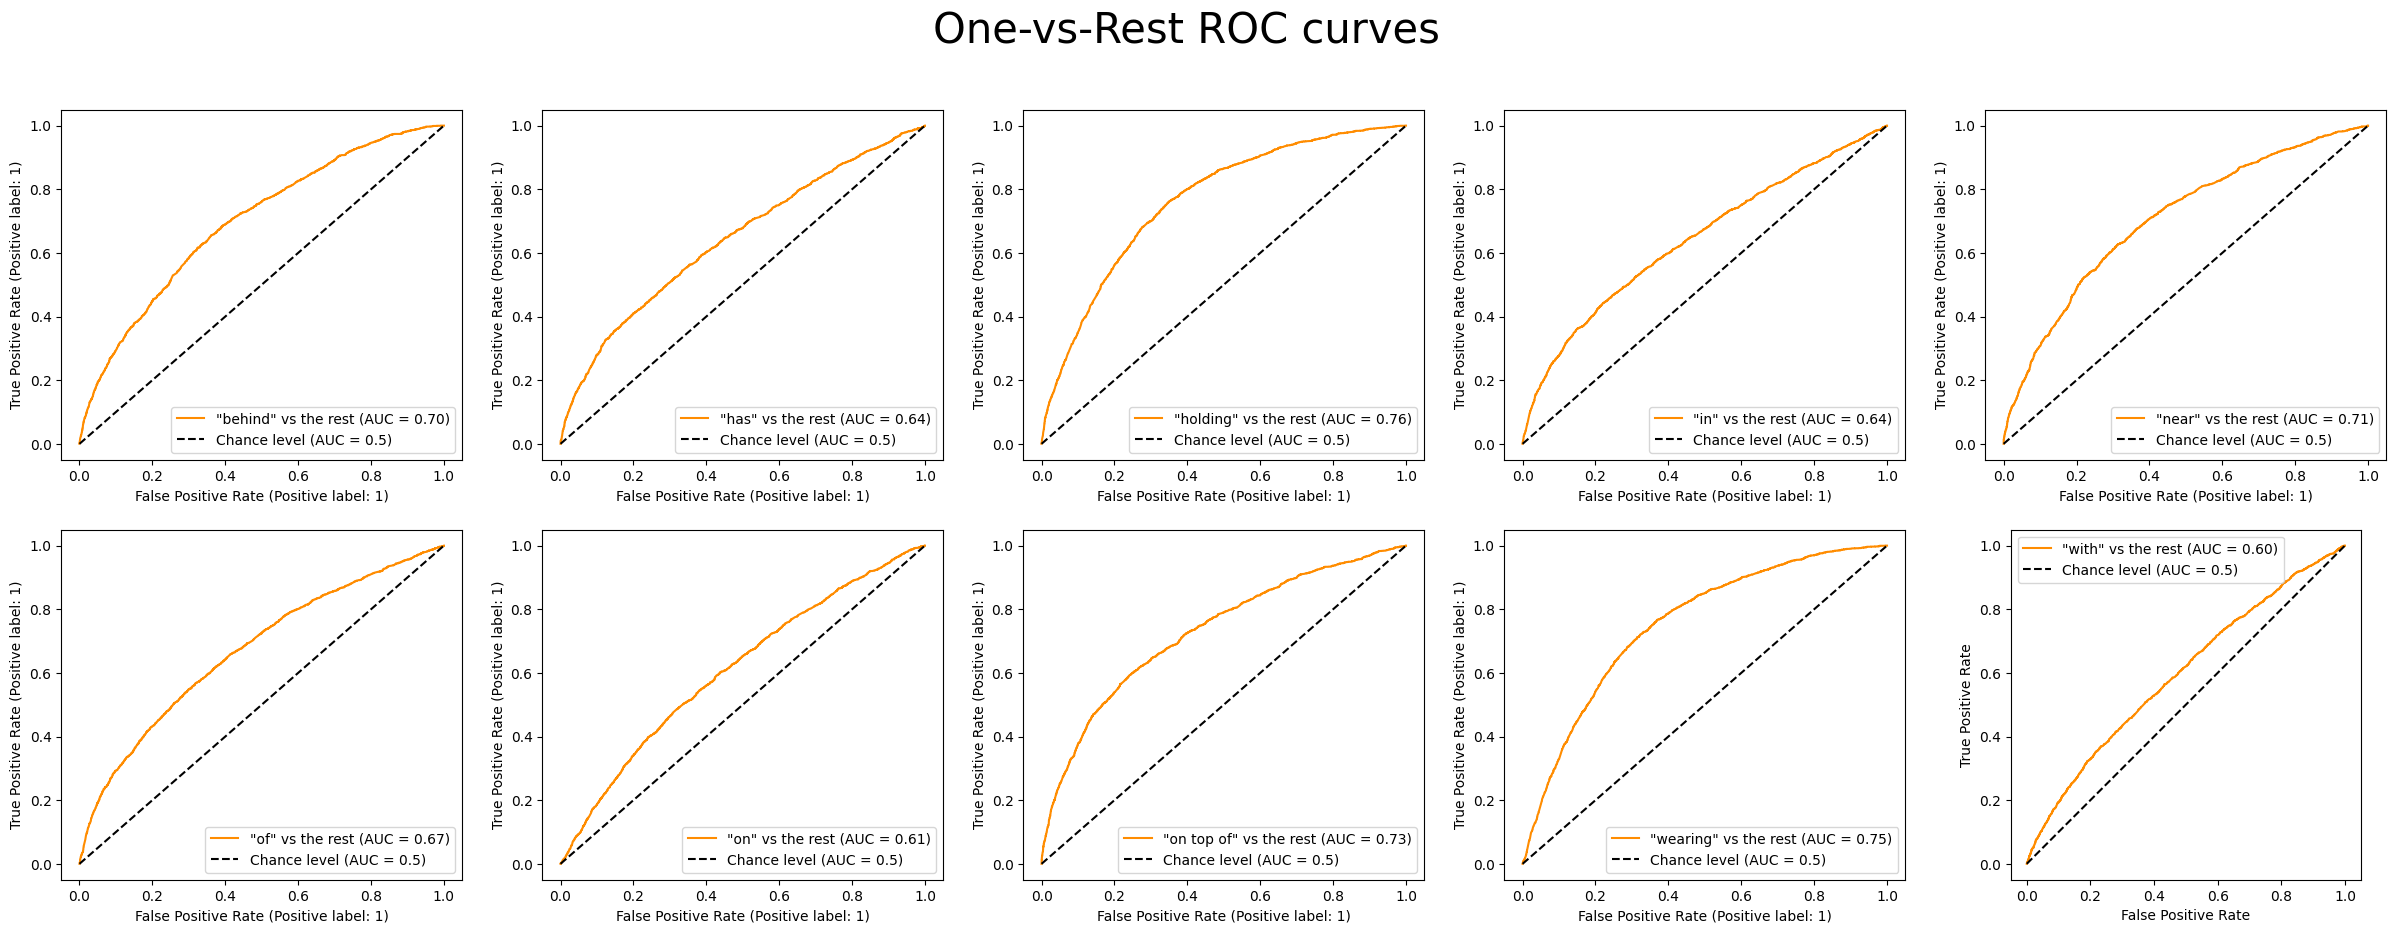

In [25]:
lr.fit(X_train_emb, y_train)
print(classification_report(y_train, lr.predict(X_train_emb)))
print(classification_report(y_test, lr.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(lr.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            lr.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            lr.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

In [14]:
svc.fit(X_train_emb, y_train)
print(classification_report(y_train, svc.predict(X_train_emb)))
print(classification_report(y_test, svc.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(svc.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            svc.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            svc.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

[LibSVM]

c:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

      behind       0.10      0.28      0.15      3969
         has       0.09      0.19      0.12      3969
     holding       0.20      0.10      0.13      3968
          in       0.14      0.09      0.11      3968
        near       0.11      0.13      0.12      3968
          of       0.14      0.03      0.05      3969
          on       0.12      0.06      0.08      3968
   on top of       0.10      0.08      0.09      3968
     wearing       0.15      0.06      0.09      3969
        with       0.10      0.11      0.11      3968

    accuracy                           0.11     39684
   macro avg       0.13      0.11      0.10     39684
weighted avg       0.13      0.11      0.10     39684

              precision    recall  f1-score   support

      behind       0.11      0.29      0.16      1954
         has       0.10      0.20      0.13      1954
     holding       0.21      0.10      0.13      1955
          in       0.16 

              precision    recall  f1-score   support

      behind       0.59      0.60      0.60      3969
         has       0.60      0.55      0.58      3969
     holding       0.50      0.62      0.55      3968
          in       0.64      0.54      0.59      3968
        near       0.62      0.64      0.63      3968
          of       0.63      0.59      0.61      3969
          on       0.62      0.51      0.56      3968
   on top of       0.61      0.68      0.64      3968
     wearing       0.48      0.63      0.54      3969
        with       0.68      0.53      0.59      3968

    accuracy                           0.59     39684
   macro avg       0.60      0.59      0.59     39684
weighted avg       0.60      0.59      0.59     39684

              precision    recall  f1-score   support

      behind       0.33      0.32      0.33      1954
         has       0.24      0.21      0.22      1954
     holding       0.28      0.34      0.31      1955
          in       0.27 

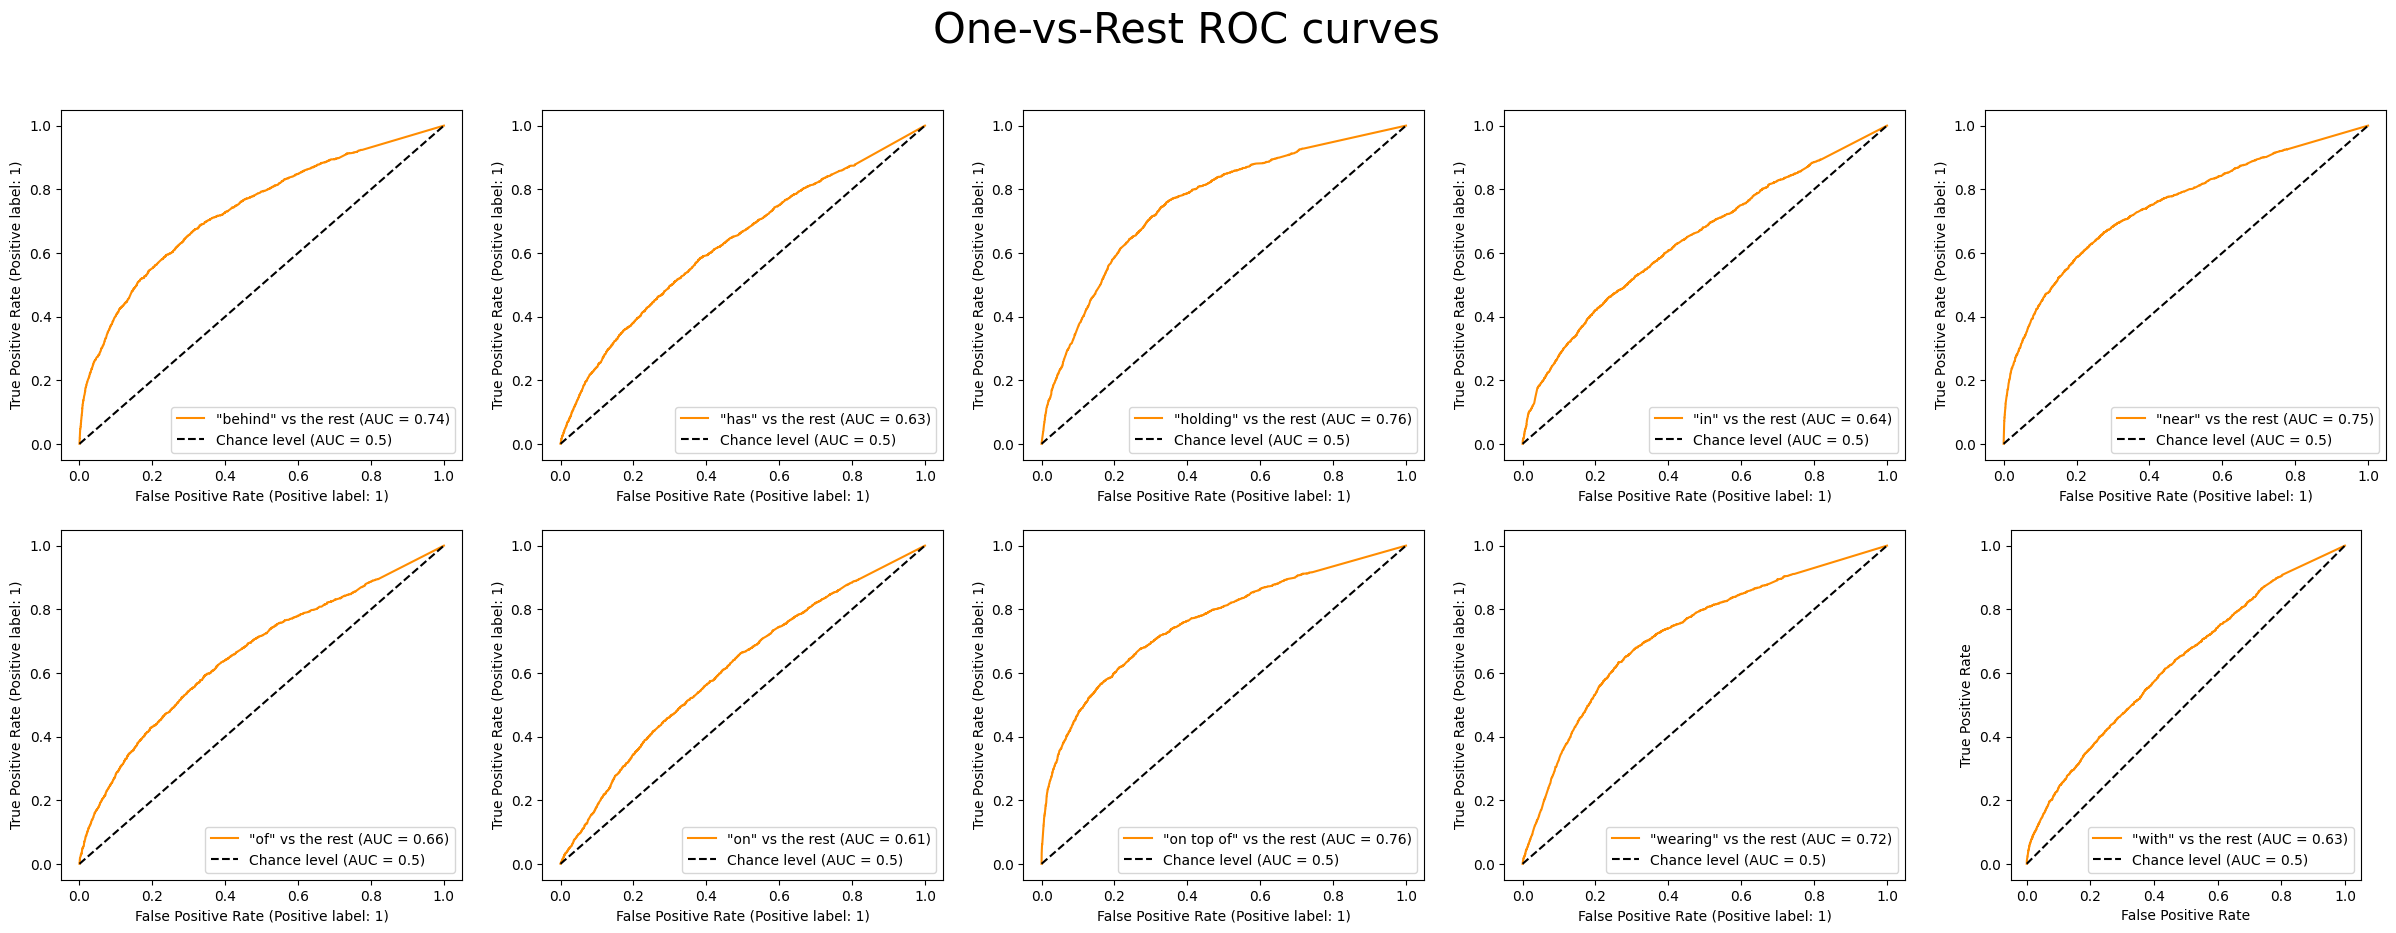

In [26]:
rf.fit(X_train_emb, y_train)
print(classification_report(y_train, rf.predict(X_train_emb)))
print(classification_report(y_test, rf.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(rf.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            rf.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            rf.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

Learning rate set to 0.095467
0:	learn: 2.2867685	total: 233ms	remaining: 3m 52s
500:	learn: 1.7860643	total: 2m 1s	remaining: 2m
999:	learn: 1.6224829	total: 4m 2s	remaining: 0us
              precision    recall  f1-score   support

      behind       0.48      0.50      0.49      3969
         has       0.49      0.44      0.46      3969
     holding       0.46      0.52      0.49      3968
          in       0.53      0.43      0.47      3968
        near       0.51      0.54      0.52      3968
          of       0.52      0.48      0.50      3969
          on       0.51      0.40      0.45      3968
   on top of       0.51      0.60      0.55      3968
     wearing       0.39      0.59      0.47      3969
        with       0.57      0.40      0.47      3968

    accuracy                           0.49     39684
   macro avg       0.50      0.49      0.49     39684
weighted avg       0.50      0.49      0.49     39684

              precision    recall  f1-score   support

      

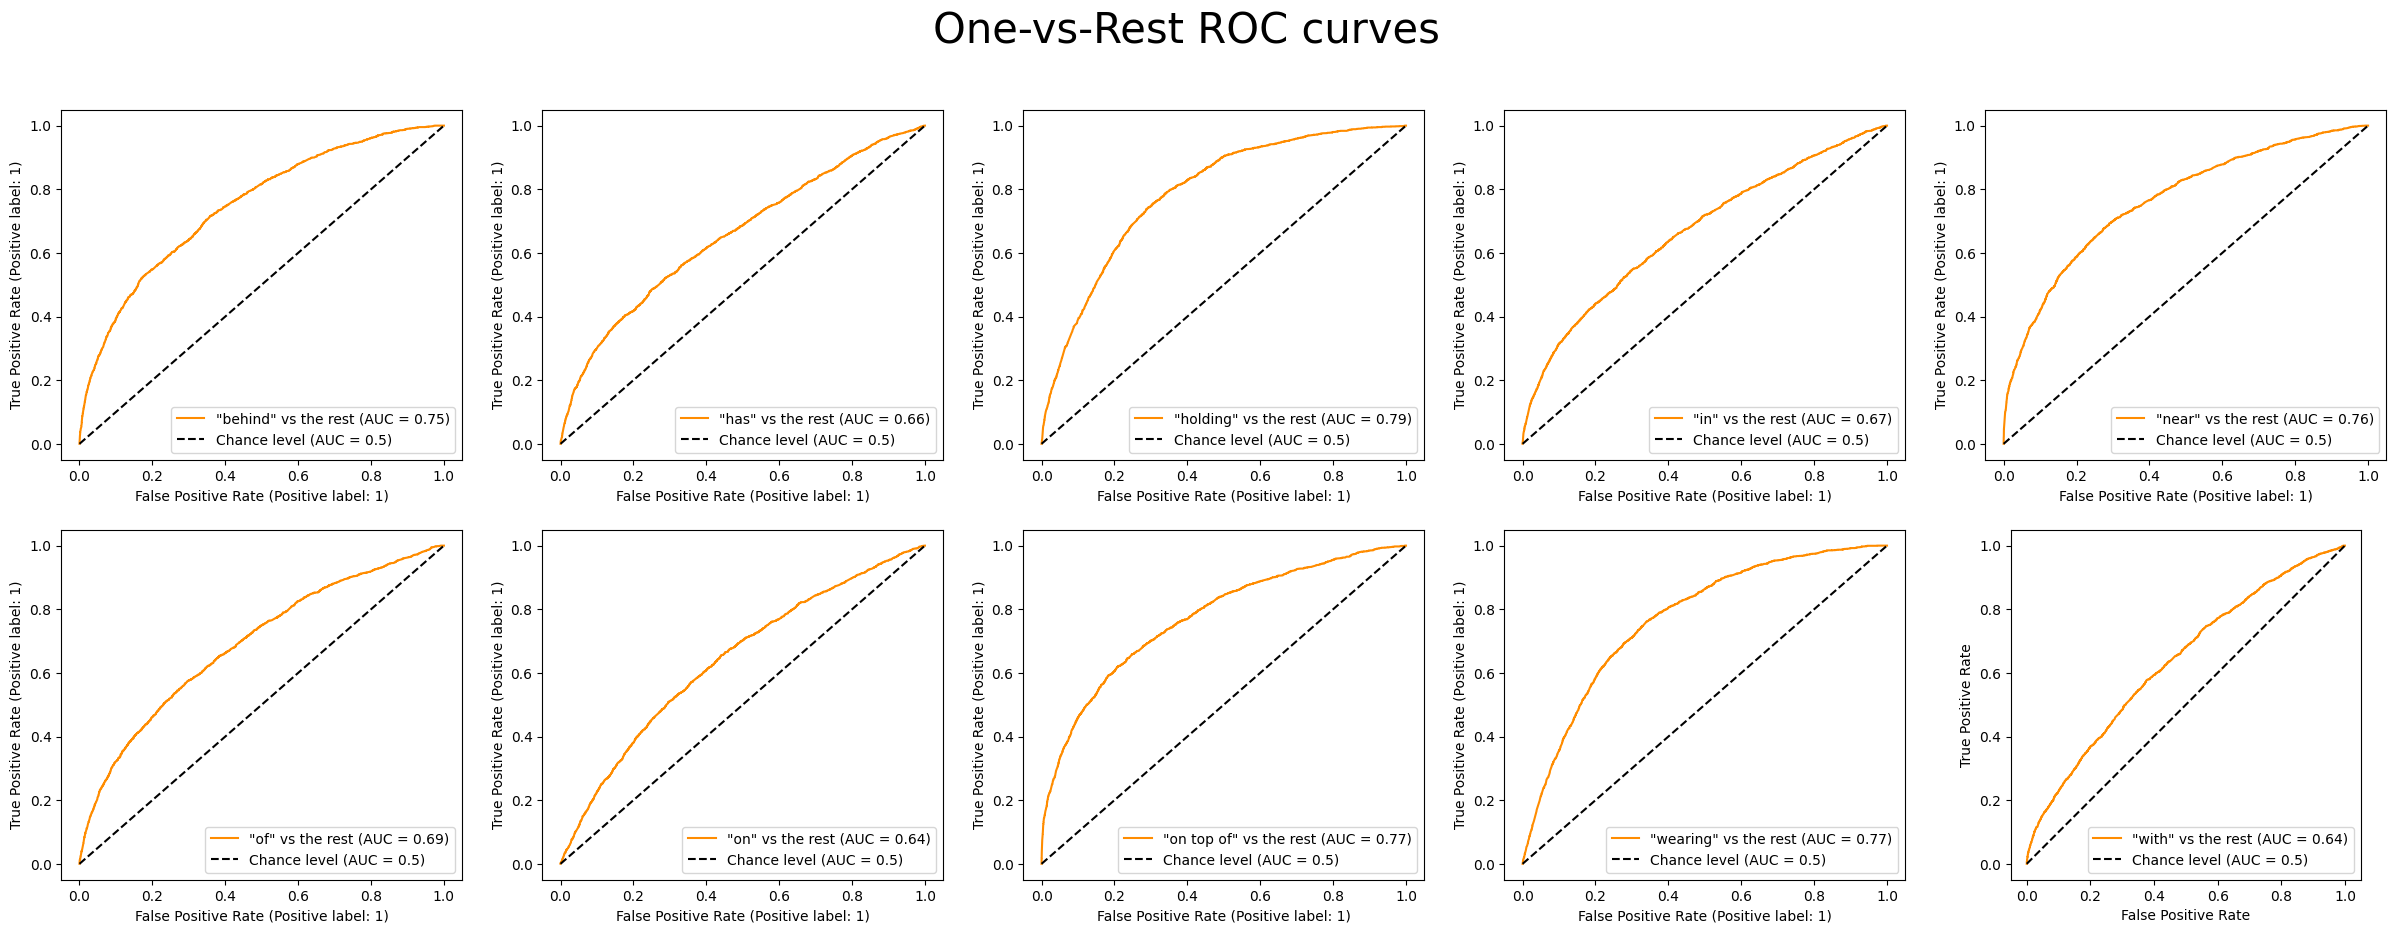

In [28]:
cb.fit(X_train_emb, y_train)
print(classification_report(y_train, cb.predict(X_train_emb)))
print(classification_report(y_test, cb.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(cb.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            cb.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            cb.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

## fasttext-wiki-news-subwords-300

In [29]:
word_vectors = api.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [30]:
X_train_emb = pd.DataFrame()
X_train_emb['objects'] = X_train['objects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(300))
X_train_emb['subjects'] = X_train['subjects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(300))

objects = np.stack(X_train_emb['objects'].values, axis=0)
subjects = np.stack(X_train_emb['subjects'].values, axis=0)
X_train_emb = np.concatenate((objects, subjects), axis=1)

In [31]:
X_test_emb = pd.DataFrame()
X_test_emb['objects'] = X_test['objects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(300))
X_test_emb['subjects'] = X_test['subjects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(300))

objects = np.stack(X_test_emb['objects'].values, axis=0)
subjects = np.stack(X_test_emb['subjects'].values, axis=0)
X_test_emb = np.concatenate((objects, subjects), axis=1)

              precision    recall  f1-score   support

      behind       0.10      0.25      0.14      3969
         has       0.10      0.15      0.12      3969
     holding       0.12      0.02      0.03      3968
          in       0.08      0.04      0.05      3968
        near       0.13      0.06      0.08      3968
          of       0.08      0.05      0.06      3969
          on       0.10      0.35      0.15      3968
   on top of       0.14      0.01      0.01      3968
     wearing       0.21      0.01      0.02      3969
        with       0.11      0.06      0.07      3968

    accuracy                           0.10     39684
   macro avg       0.12      0.10      0.08     39684
weighted avg       0.12      0.10      0.08     39684

              precision    recall  f1-score   support

      behind       0.09      0.24      0.13      1954
         has       0.09      0.15      0.11      1954
     holding       0.12      0.02      0.03      1955
          in       0.10 

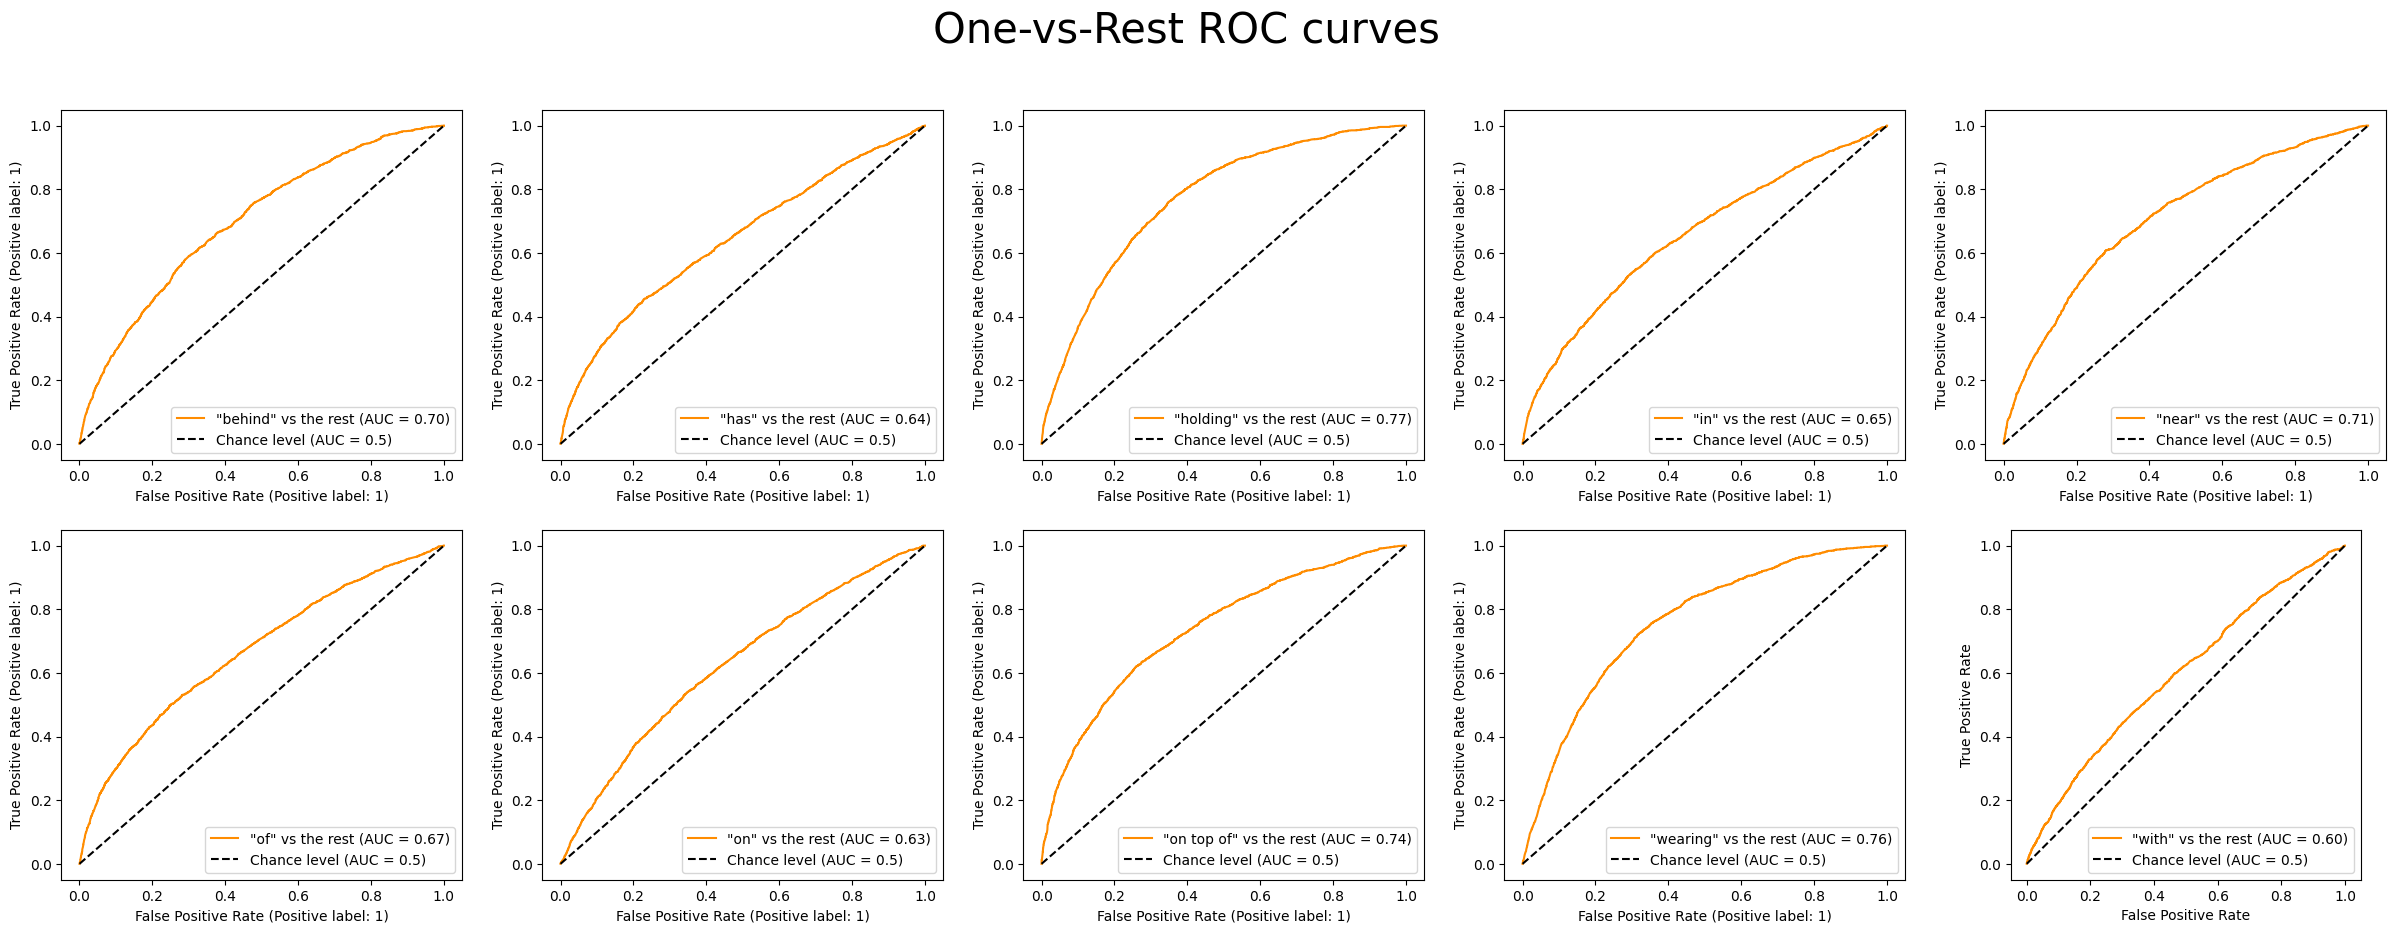

In [32]:
lr.fit(X_train_emb, y_train)
print(classification_report(y_train, lr.predict(X_train_emb)))
print(classification_report(y_test, lr.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(lr.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            lr.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            lr.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

In [21]:
svc.fit(X_train_emb, y_train)
print(classification_report(y_train, svc.predict(X_train_emb)))
print(classification_report(y_test, svc.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(svc.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            svc.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            svc.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

[LibSVM]

c:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

      behind       0.11      0.27      0.16      3969
         has       0.14      0.20      0.16      3969
     holding       0.13      0.15      0.14      3968
          in       0.13      0.12      0.12      3968
        near       0.12      0.08      0.10      3968
          of       0.11      0.06      0.08      3969
          on       0.14      0.10      0.12      3968
   on top of       0.11      0.08      0.09      3968
     wearing       0.22      0.16      0.18      3969
        with       0.11      0.09      0.10      3968

    accuracy                           0.13     39684
   macro avg       0.13      0.13      0.13     39684
weighted avg       0.13      0.13      0.13     39684

              precision    recall  f1-score   support

      behind       0.12      0.27      0.16      1954
         has       0.14      0.19      0.16      1954
     holding       0.14      0.16      0.15      1955
          in       0.11 

              precision    recall  f1-score   support

      behind       0.59      0.61      0.60      3969
         has       0.59      0.57      0.58      3969
     holding       0.55      0.59      0.57      3968
          in       0.64      0.54      0.59      3968
        near       0.61      0.64      0.62      3968
          of       0.64      0.58      0.61      3969
          on       0.57      0.53      0.55      3968
   on top of       0.63      0.67      0.65      3968
     wearing       0.47      0.64      0.54      3969
        with       0.68      0.53      0.59      3968

    accuracy                           0.59     39684
   macro avg       0.60      0.59      0.59     39684
weighted avg       0.60      0.59      0.59     39684

              precision    recall  f1-score   support

      behind       0.32      0.32      0.32      1954
         has       0.23      0.21      0.22      1954
     holding       0.30      0.32      0.31      1955
          in       0.27 

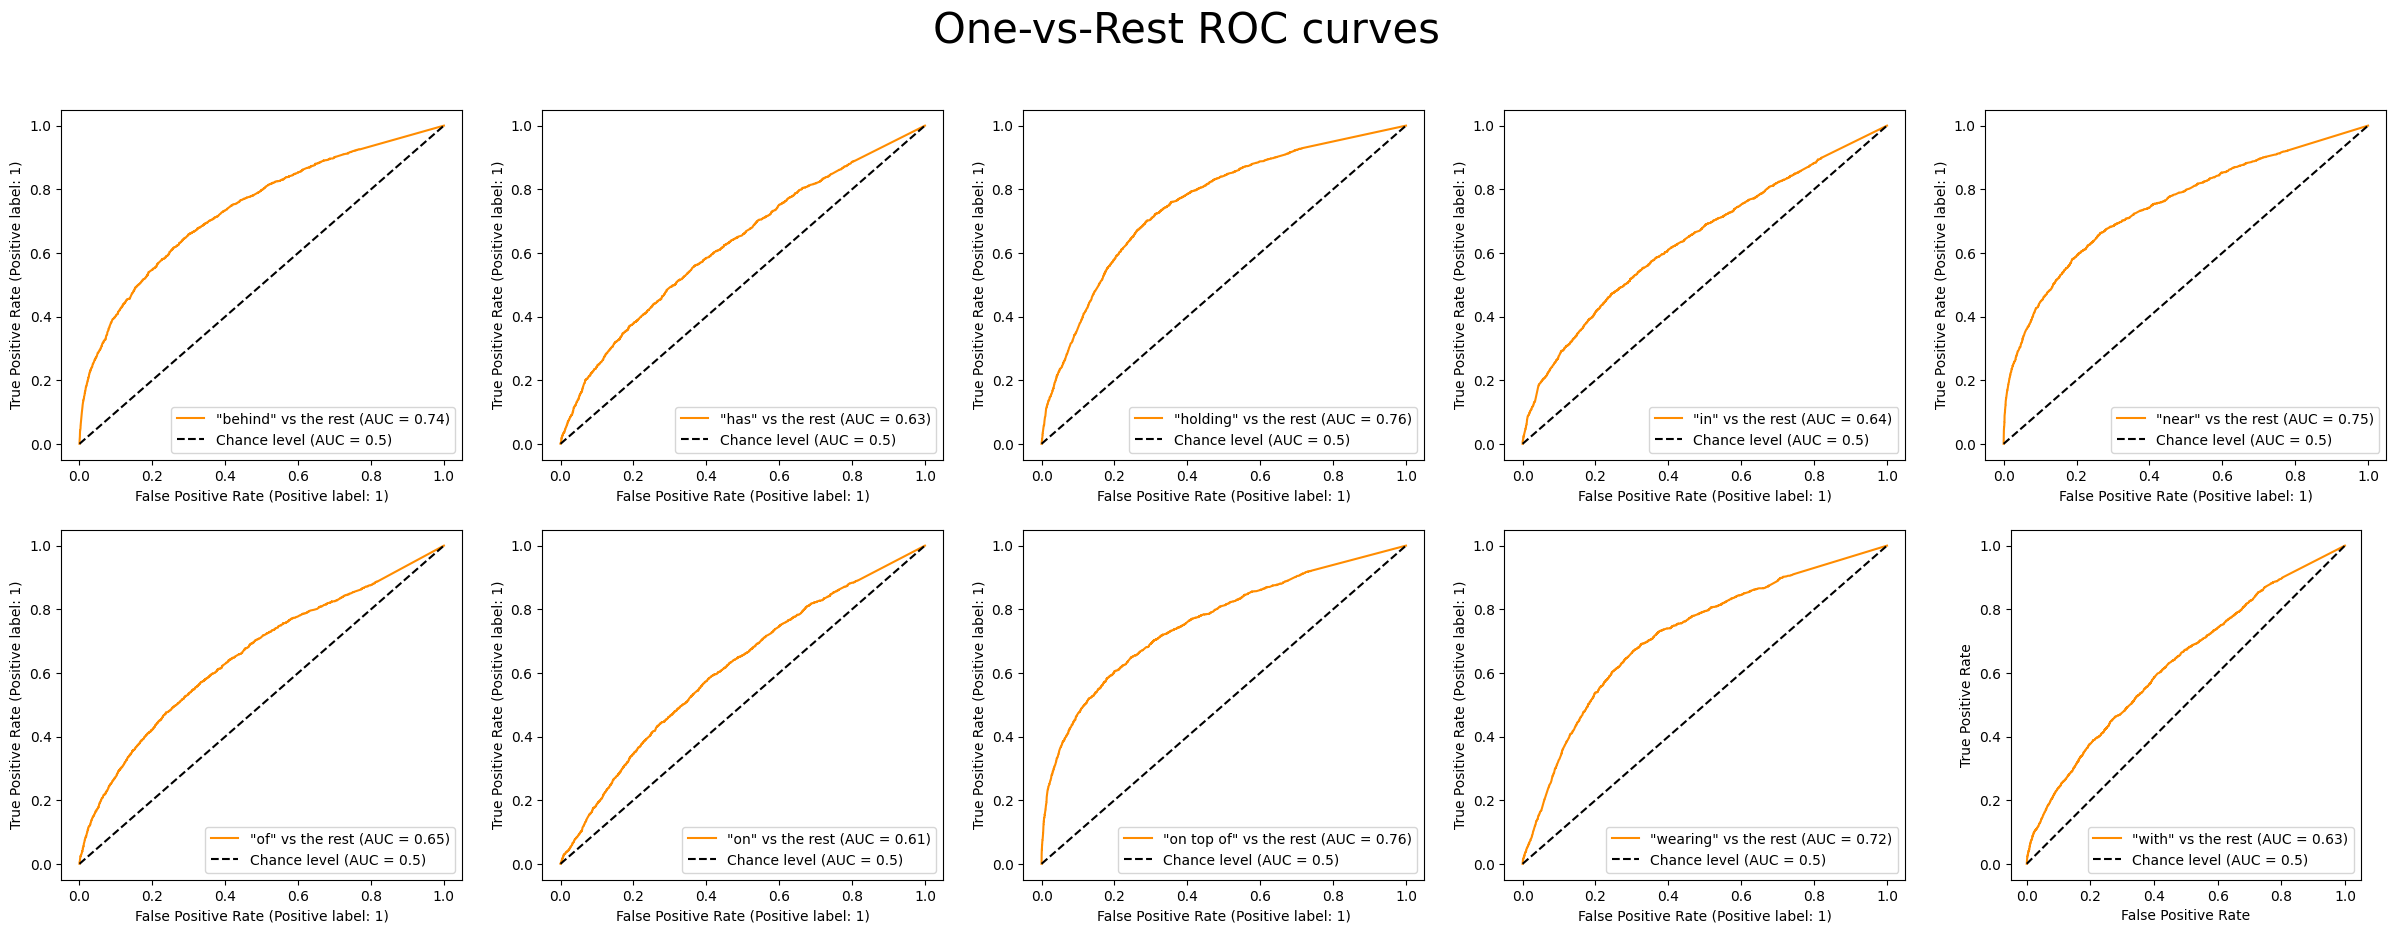

In [33]:
rf.fit(X_train_emb, y_train)
print(classification_report(y_train, rf.predict(X_train_emb)))
print(classification_report(y_test, rf.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(rf.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            rf.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            rf.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

Learning rate set to 0.095467
0:	learn: 2.2872628	total: 221ms	remaining: 3m 41s
500:	learn: 1.7755095	total: 2m	remaining: 1m 59s
999:	learn: 1.6113464	total: 4m	remaining: 0us
              precision    recall  f1-score   support

      behind       0.53      0.49      0.51      3969
         has       0.49      0.45      0.47      3969
     holding       0.45      0.54      0.49      3968
          in       0.52      0.43      0.47      3968
        near       0.52      0.53      0.53      3968
          of       0.52      0.48      0.50      3969
          on       0.46      0.41      0.44      3968
   on top of       0.52      0.60      0.56      3968
     wearing       0.40      0.58      0.47      3969
        with       0.57      0.41      0.48      3968

    accuracy                           0.49     39684
   macro avg       0.50      0.49      0.49     39684
weighted avg       0.50      0.49      0.49     39684

              precision    recall  f1-score   support

      be

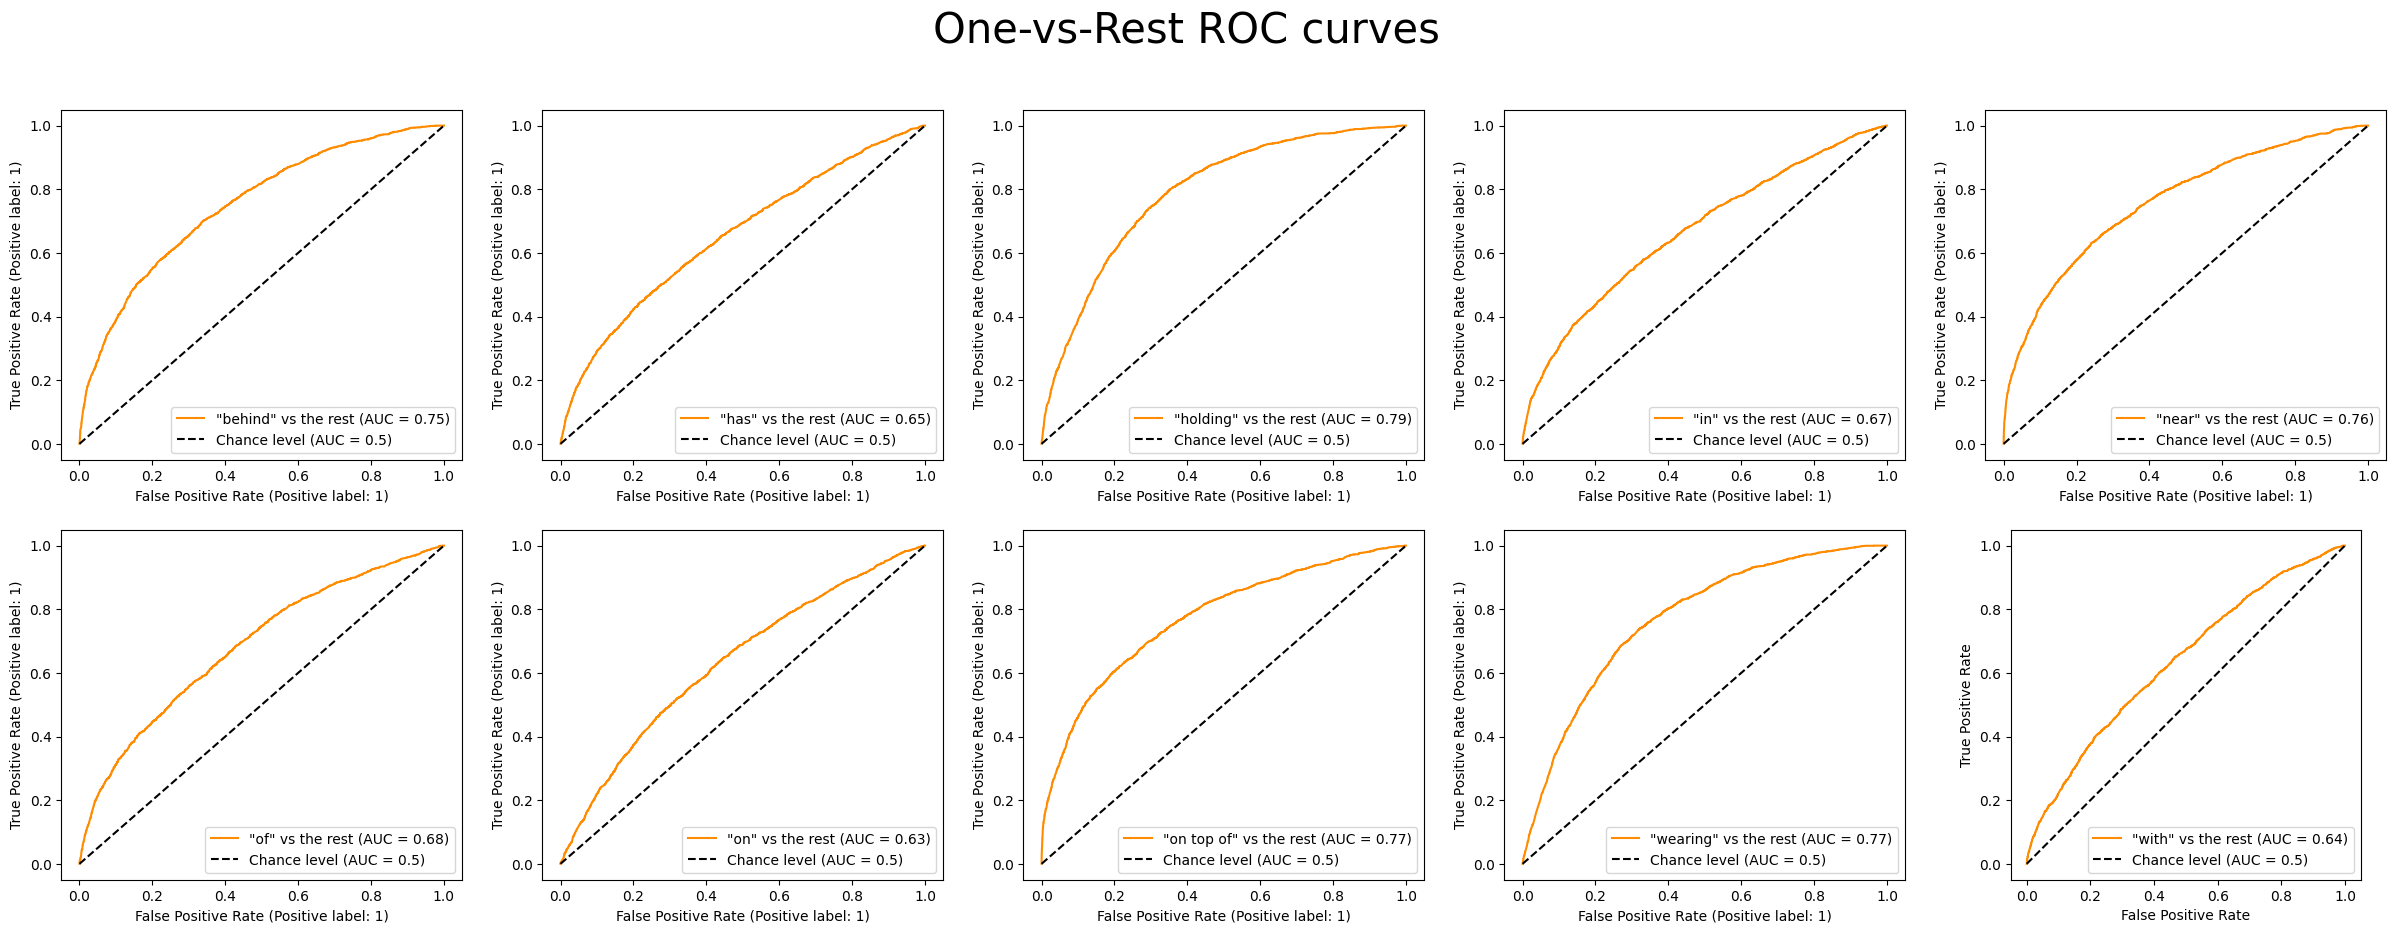

In [34]:
cb.fit(X_train_emb, y_train)
print(classification_report(y_train, cb.predict(X_train_emb)))
print(classification_report(y_test, cb.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(cb.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            cb.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            cb.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

## glove-wiki-gigaword-100

In [35]:
word_vectors = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [39]:
X_train_emb = pd.DataFrame()
X_train_emb['objects'] = X_train['objects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(100))
X_train_emb['subjects'] = X_train['subjects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(100))

objects = np.stack(X_train_emb['objects'].values, axis=0)
subjects = np.stack(X_train_emb['subjects'].values, axis=0)
X_train_emb = np.concatenate((objects, subjects), axis=1)

In [40]:
X_test_emb = pd.DataFrame()
X_test_emb['objects'] = X_test['objects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(100))
X_test_emb['subjects'] = X_test['subjects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(100))

objects = np.stack(X_test_emb['objects'].values, axis=0)
subjects = np.stack(X_test_emb['subjects'].values, axis=0)
X_test_emb = np.concatenate((objects, subjects), axis=1)

              precision    recall  f1-score   support

      behind       0.23      0.21      0.22      3969
         has       0.25      0.25      0.25      3969
     holding       0.27      0.35      0.31      3968
          in       0.26      0.21      0.23      3968
        near       0.24      0.27      0.25      3968
          of       0.26      0.26      0.26      3969
          on       0.20      0.11      0.14      3968
   on top of       0.27      0.39      0.32      3968
     wearing       0.27      0.36      0.31      3969
        with       0.21      0.11      0.15      3968

    accuracy                           0.25     39684
   macro avg       0.25      0.25      0.24     39684
weighted avg       0.25      0.25      0.24     39684

              precision    recall  f1-score   support

      behind       0.22      0.20      0.21      1954
         has       0.23      0.23      0.23      1954
     holding       0.26      0.34      0.30      1955
          in       0.24 

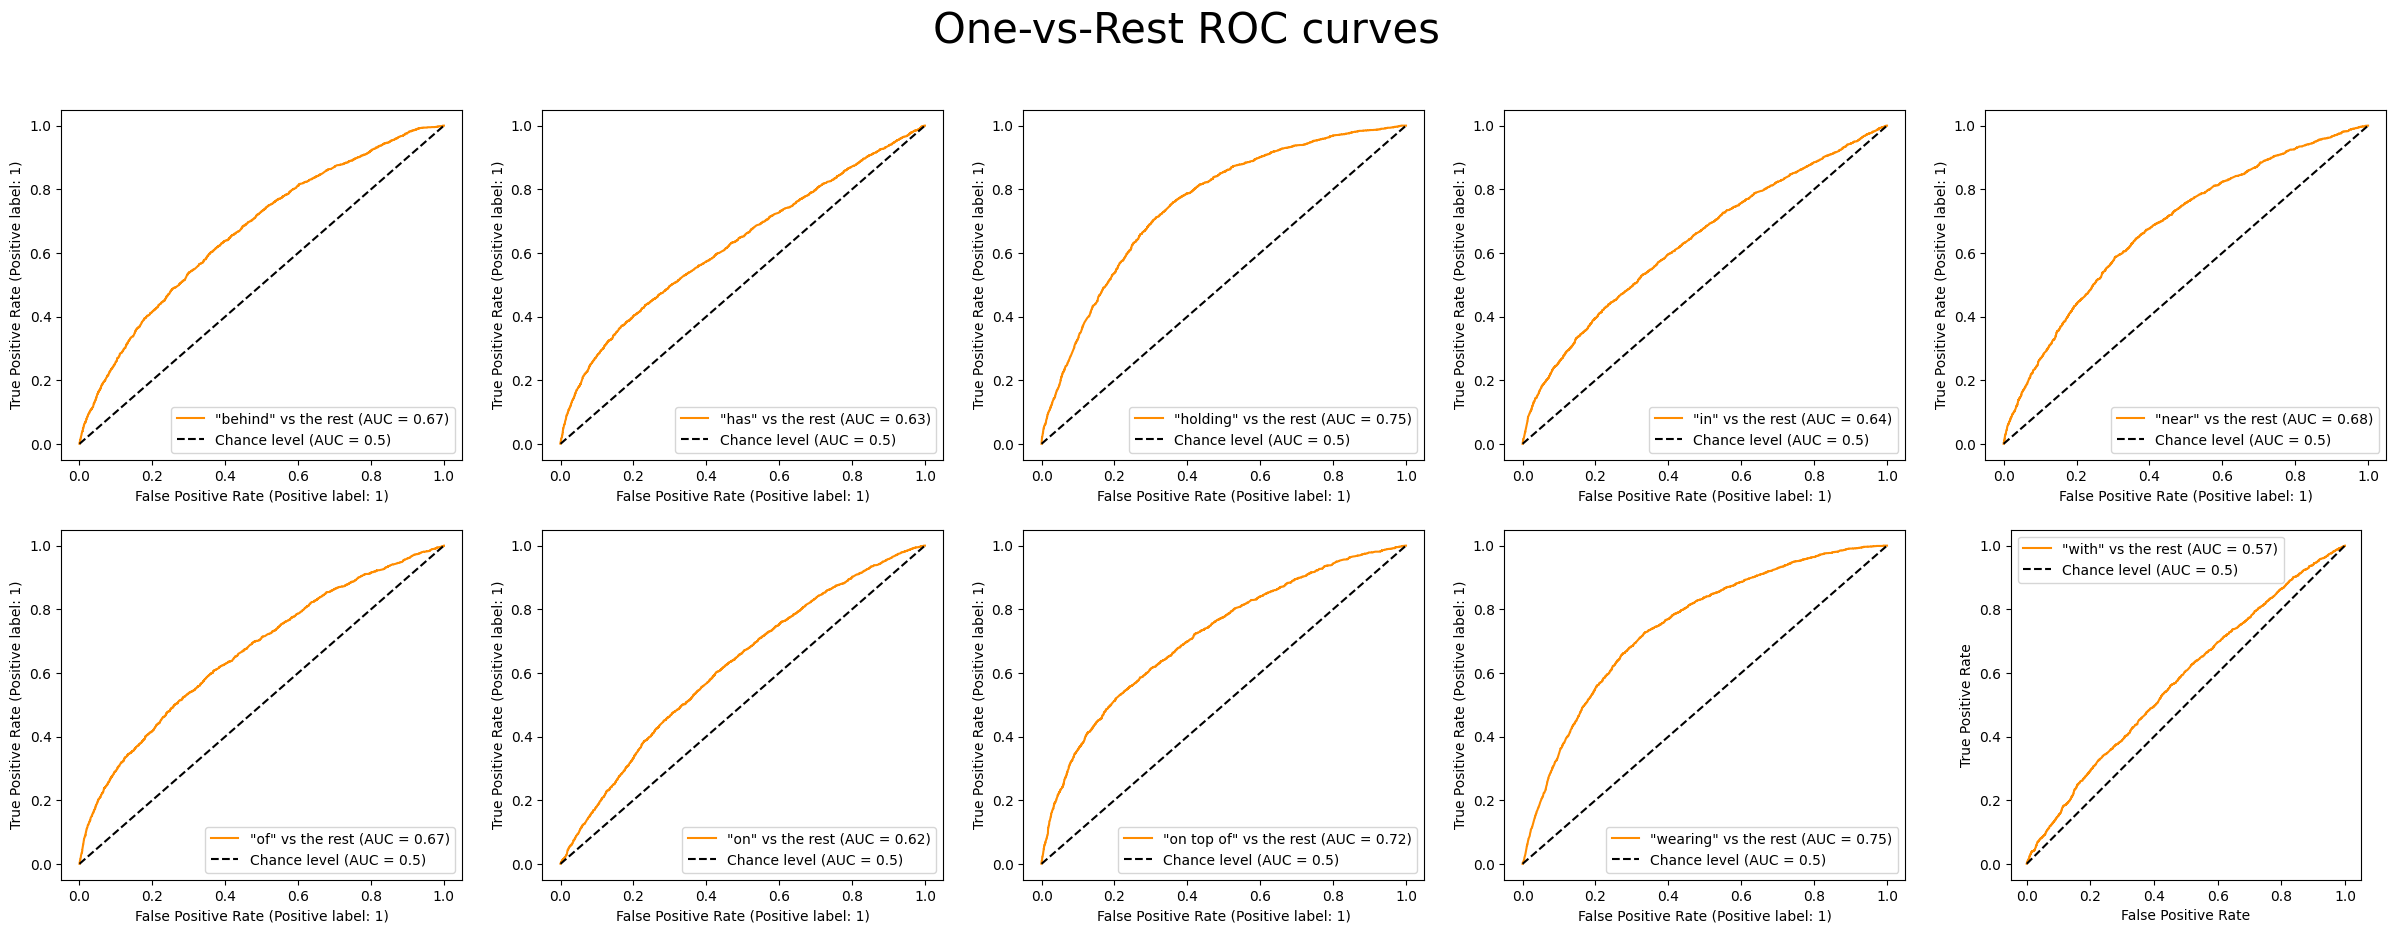

In [42]:
lr.fit(X_train_emb, y_train)
print(classification_report(y_train, lr.predict(X_train_emb)))
print(classification_report(y_test, lr.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(lr.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            lr.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            lr.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

In [ ]:
svc.fit(X_train_emb, y_train)
print(classification_report(y_train, svc.predict(X_train_emb)))
print(classification_report(y_test, svc.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(svc.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            svc.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            svc.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

[LibSVM]

c:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

      behind       0.11      0.27      0.16      3969
         has       0.14      0.20      0.16      3969
     holding       0.13      0.15      0.14      3968
          in       0.13      0.12      0.12      3968
        near       0.12      0.08      0.10      3968
          of       0.11      0.06      0.08      3969
          on       0.14      0.10      0.12      3968
   on top of       0.11      0.08      0.09      3968
     wearing       0.22      0.16      0.18      3969
        with       0.11      0.09      0.10      3968

    accuracy                           0.13     39684
   macro avg       0.13      0.13      0.13     39684
weighted avg       0.13      0.13      0.13     39684

              precision    recall  f1-score   support

      behind       0.12      0.27      0.16      1954
         has       0.14      0.19      0.16      1954
     holding       0.14      0.16      0.15      1955
          in       0.11 

              precision    recall  f1-score   support

      behind       0.59      0.61      0.60      3969
         has       0.61      0.56      0.58      3969
     holding       0.55      0.60      0.57      3968
          in       0.64      0.54      0.59      3968
        near       0.61      0.64      0.63      3968
          of       0.64      0.58      0.61      3969
          on       0.57      0.53      0.55      3968
   on top of       0.62      0.67      0.65      3968
     wearing       0.48      0.63      0.54      3969
        with       0.66      0.53      0.59      3968

    accuracy                           0.59     39684
   macro avg       0.60      0.59      0.59     39684
weighted avg       0.60      0.59      0.59     39684

              precision    recall  f1-score   support

      behind       0.32      0.34      0.33      1954
         has       0.25      0.21      0.23      1954
     holding       0.30      0.32      0.31      1955
          in       0.27 

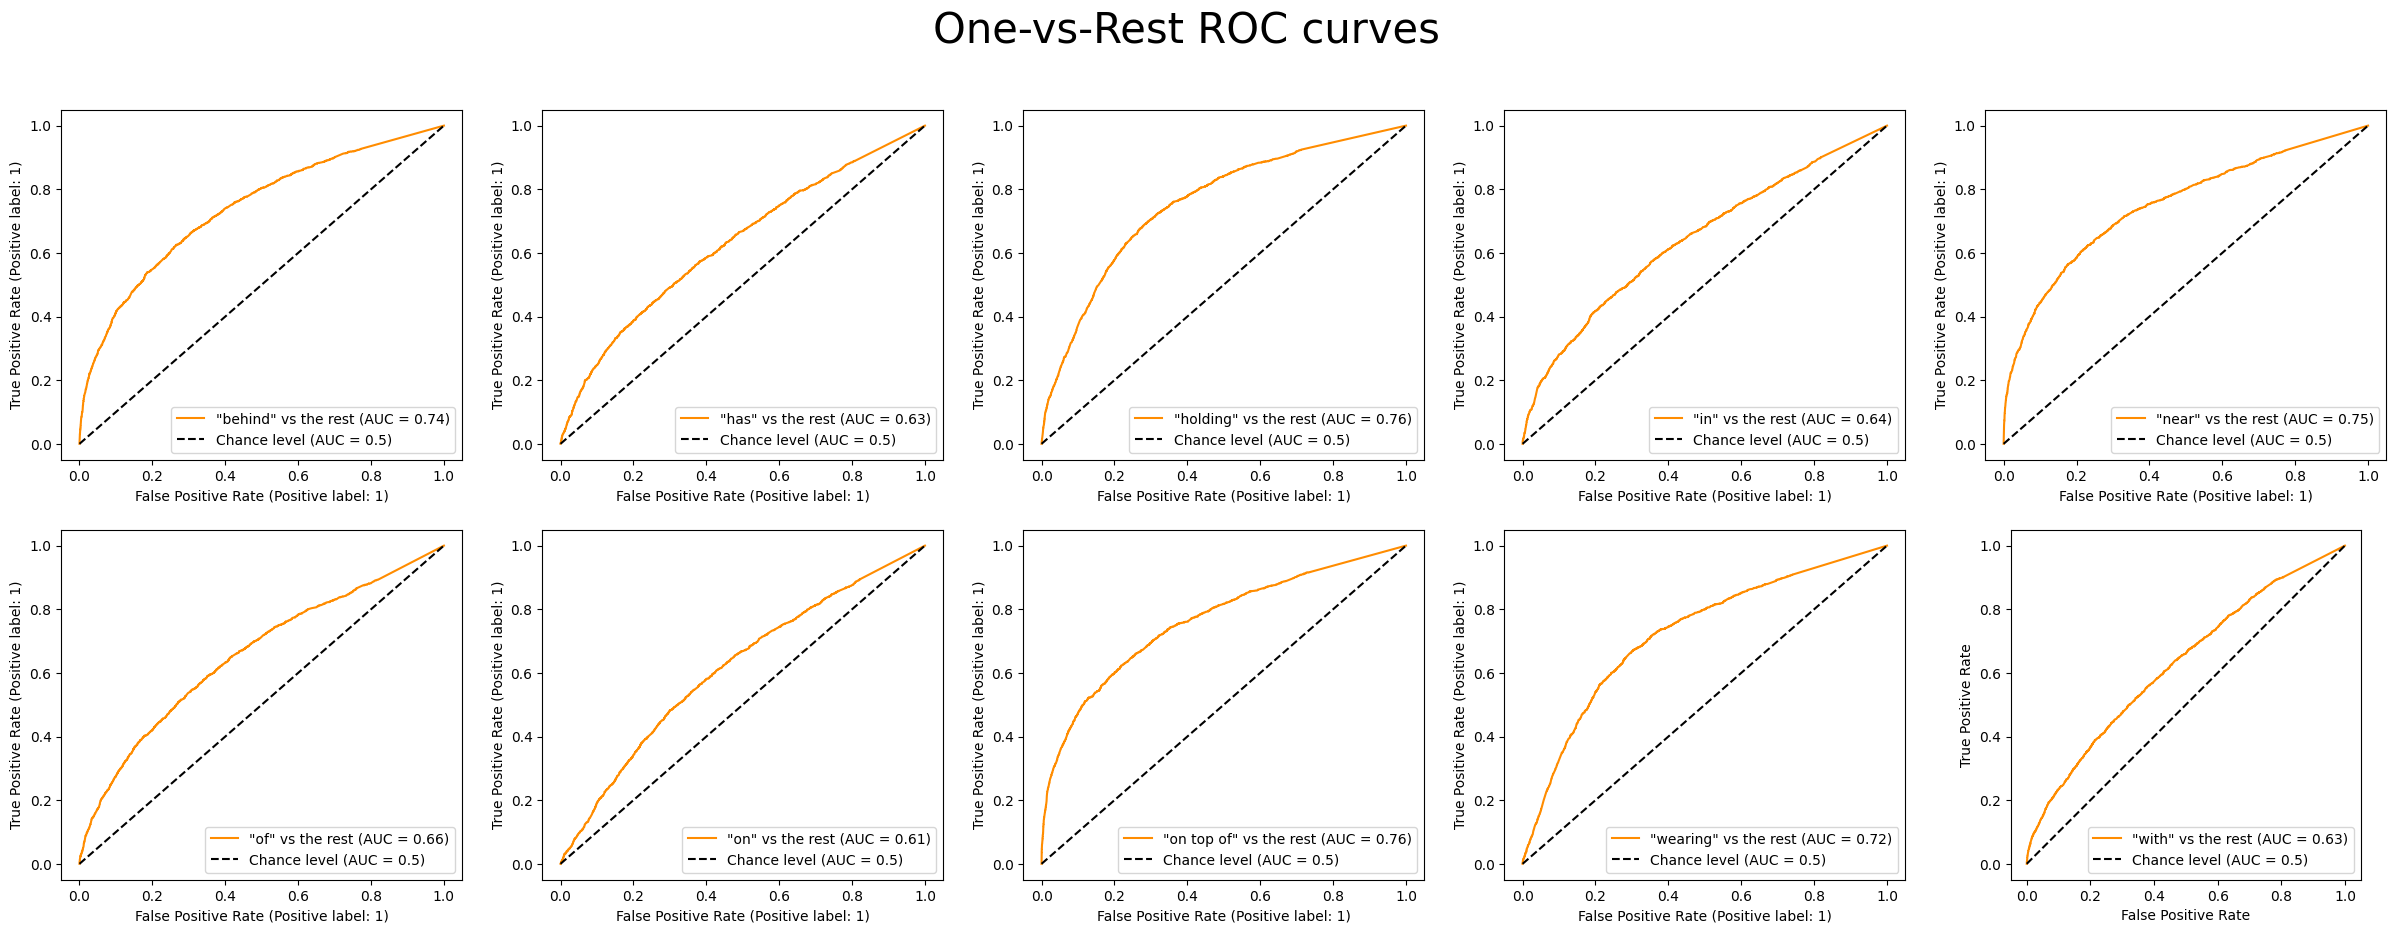

In [43]:
rf.fit(X_train_emb, y_train)
print(classification_report(y_train, rf.predict(X_train_emb)))
print(classification_report(y_test, rf.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(rf.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            rf.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            rf.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

Learning rate set to 0.095467
0:	learn: 2.2868229	total: 90.9ms	remaining: 1m 30s
500:	learn: 1.7902623	total: 42.6s	remaining: 42.4s
999:	learn: 1.6306628	total: 1m 26s	remaining: 0us
              precision    recall  f1-score   support

      behind       0.50      0.50      0.50      3969
         has       0.49      0.44      0.46      3969
     holding       0.44      0.53      0.48      3968
          in       0.53      0.43      0.47      3968
        near       0.53      0.53      0.53      3968
          of       0.51      0.48      0.49      3969
          on       0.47      0.40      0.43      3968
   on top of       0.52      0.59      0.55      3968
     wearing       0.39      0.57      0.47      3969
        with       0.56      0.40      0.47      3968

    accuracy                           0.49     39684
   macro avg       0.49      0.49      0.49     39684
weighted avg       0.49      0.49      0.49     39684

              precision    recall  f1-score   support

 

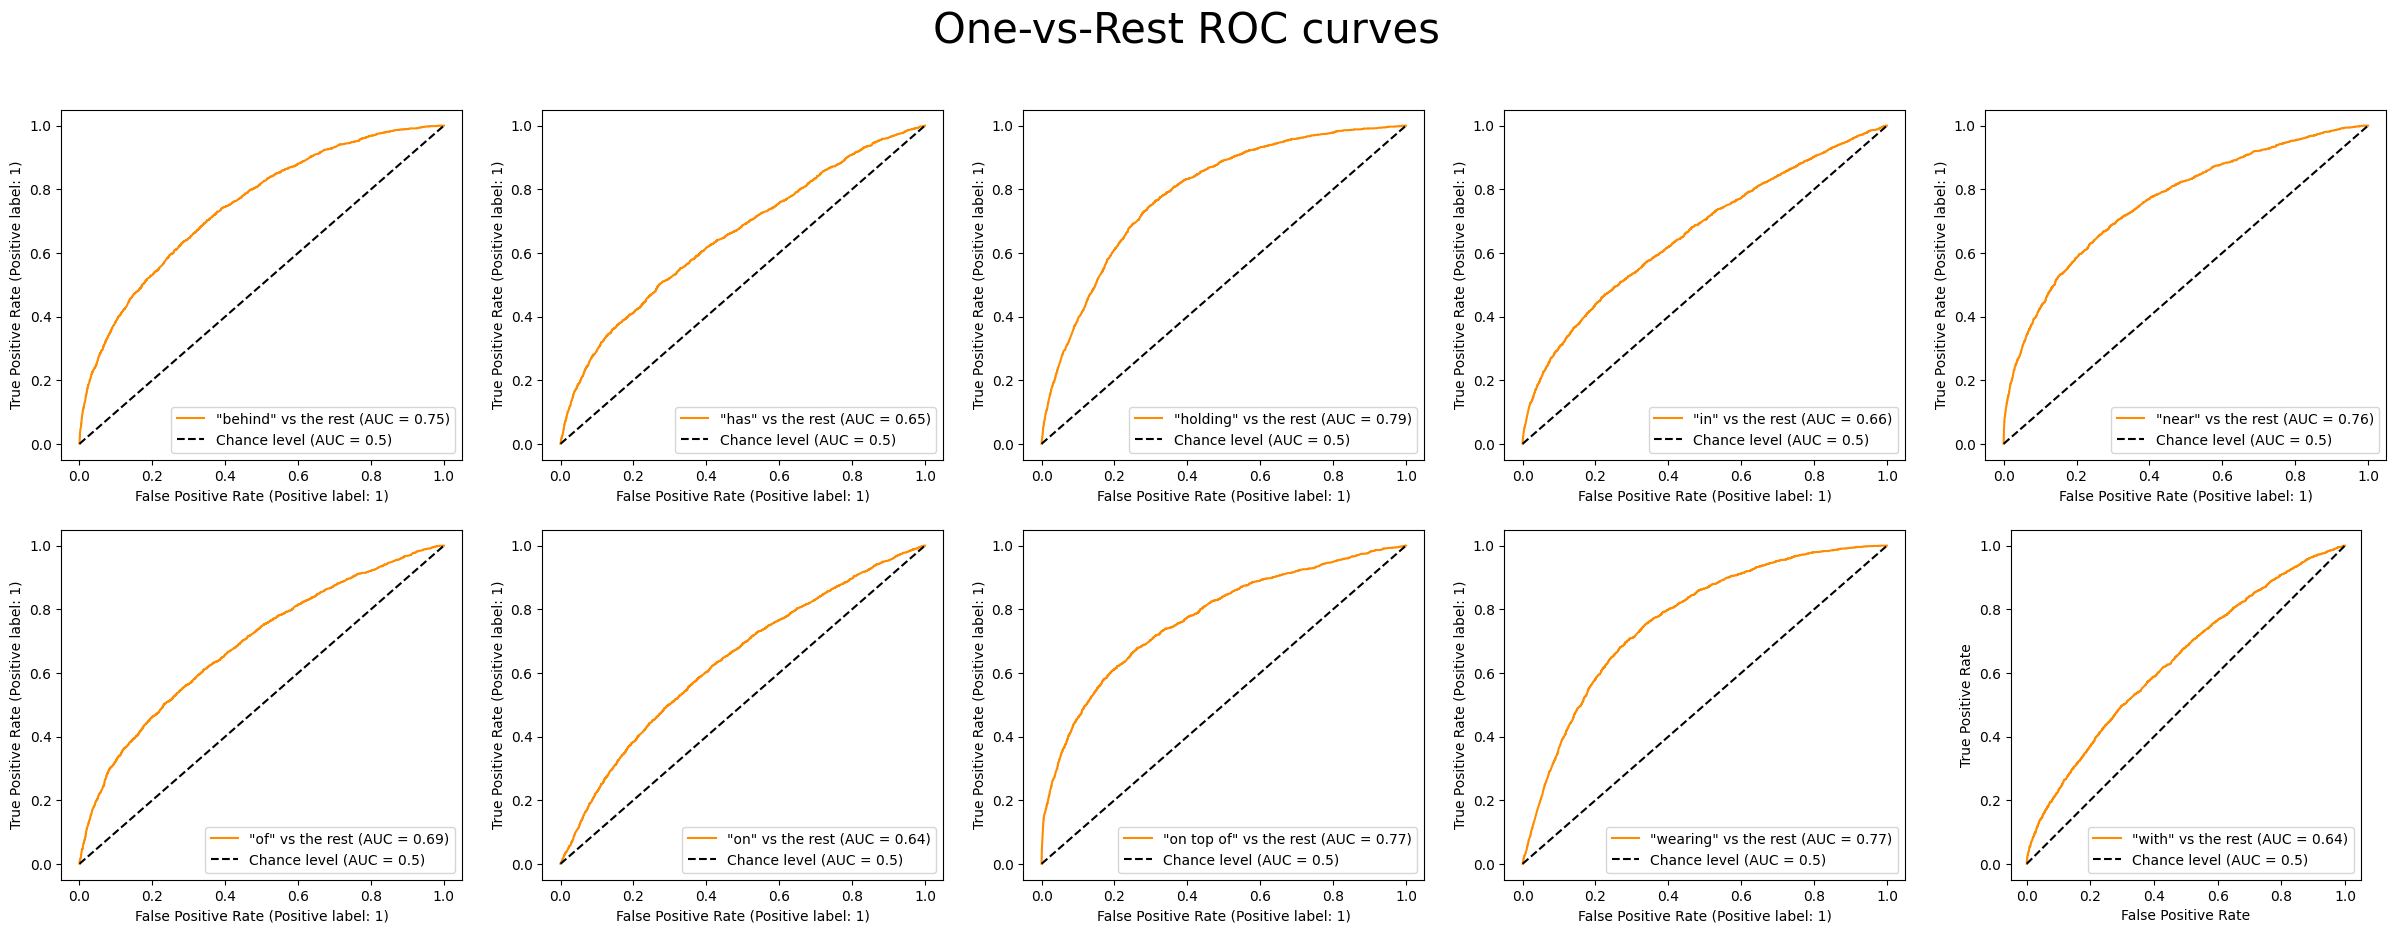

In [44]:
cb.fit(X_train_emb, y_train)
print(classification_report(y_train, cb.predict(X_train_emb)))
print(classification_report(y_test, cb.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(cb.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            cb.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            cb.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

## glove-wiki-gigaword-300

In [45]:
word_vectors = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [46]:
X_train_emb = pd.DataFrame()
X_train_emb['objects'] = X_train['objects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(300))
X_train_emb['subjects'] = X_train['subjects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(300))

objects = np.stack(X_train_emb['objects'].values, axis=0)
subjects = np.stack(X_train_emb['subjects'].values, axis=0)
X_train_emb = np.concatenate((objects, subjects), axis=1)

In [47]:
X_test_emb = pd.DataFrame()
X_test_emb['objects'] = X_test['objects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(300))
X_test_emb['subjects'] = X_test['subjects'].apply(lambda x: word_vectors[x] if x in word_vectors else np.zeros(300))

objects = np.stack(X_test_emb['objects'].values, axis=0)
subjects = np.stack(X_test_emb['subjects'].values, axis=0)
X_test_emb = np.concatenate((objects, subjects), axis=1)

              precision    recall  f1-score   support

      behind       0.31      0.28      0.29      3969
         has       0.29      0.25      0.27      3969
     holding       0.30      0.39      0.34      3968
          in       0.29      0.23      0.26      3968
        near       0.30      0.33      0.32      3968
          of       0.30      0.27      0.28      3969
          on       0.22      0.18      0.20      3968
   on top of       0.33      0.40      0.36      3968
     wearing       0.29      0.41      0.34      3969
        with       0.27      0.17      0.21      3968

    accuracy                           0.29     39684
   macro avg       0.29      0.29      0.29     39684
weighted avg       0.29      0.29      0.29     39684

              precision    recall  f1-score   support

      behind       0.28      0.25      0.26      1954
         has       0.23      0.20      0.22      1954
     holding       0.27      0.35      0.31      1955
          in       0.25 

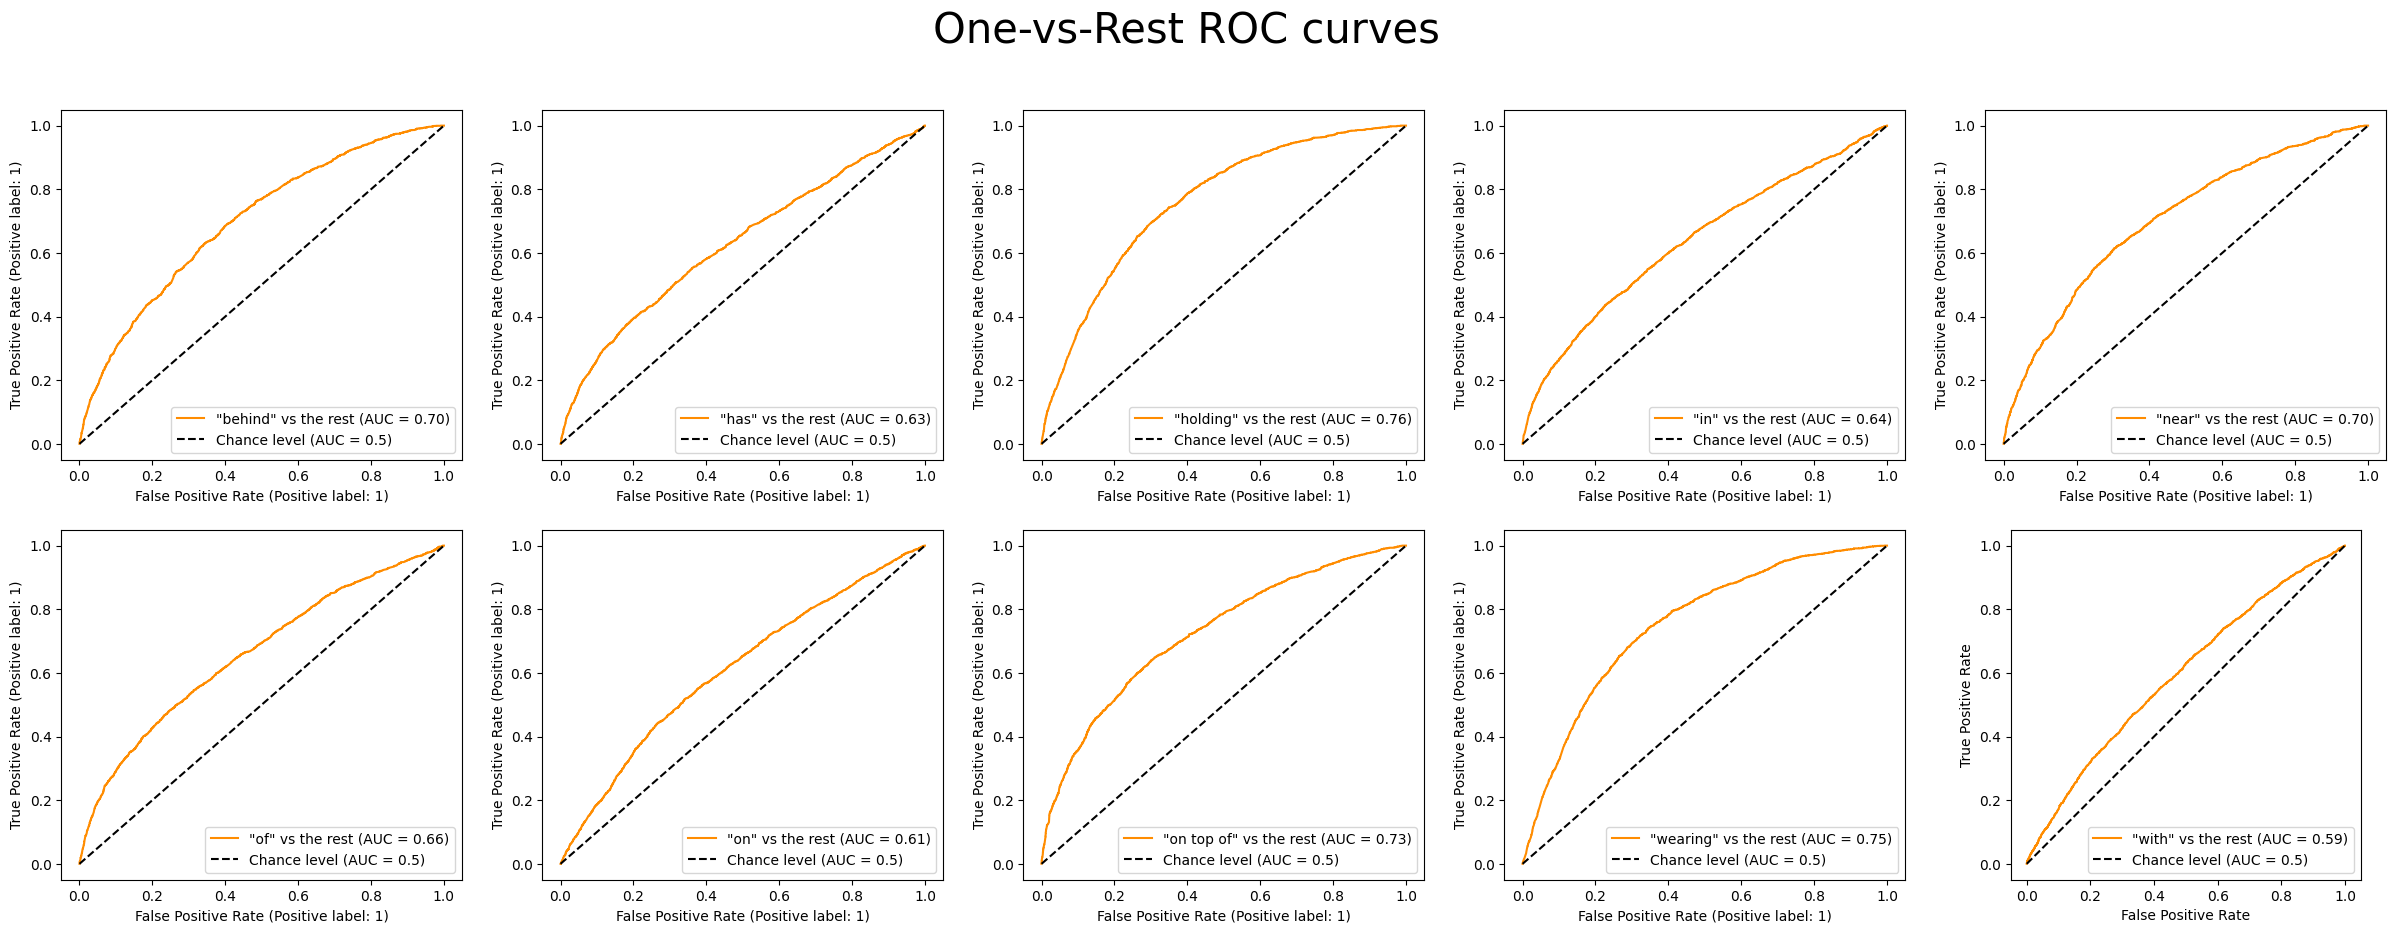

In [48]:
lr.fit(X_train_emb, y_train)
print(classification_report(y_train, lr.predict(X_train_emb)))
print(classification_report(y_test, lr.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(lr.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            lr.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            lr.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

In [ ]:
svc.fit(X_train_emb, y_train)
print(classification_report(y_train, svc.predict(X_train_emb)))
print(classification_report(y_test, svc.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(svc.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            svc.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            svc.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

[LibSVM]

c:\Users\mi\anaconda3\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

      behind       0.11      0.27      0.16      3969
         has       0.14      0.20      0.16      3969
     holding       0.13      0.15      0.14      3968
          in       0.13      0.12      0.12      3968
        near       0.12      0.08      0.10      3968
          of       0.11      0.06      0.08      3969
          on       0.14      0.10      0.12      3968
   on top of       0.11      0.08      0.09      3968
     wearing       0.22      0.16      0.18      3969
        with       0.11      0.09      0.10      3968

    accuracy                           0.13     39684
   macro avg       0.13      0.13      0.13     39684
weighted avg       0.13      0.13      0.13     39684

              precision    recall  f1-score   support

      behind       0.12      0.27      0.16      1954
         has       0.14      0.19      0.16      1954
     holding       0.14      0.16      0.15      1955
          in       0.11 

              precision    recall  f1-score   support

      behind       0.58      0.61      0.60      3969
         has       0.60      0.56      0.58      3969
     holding       0.53      0.59      0.56      3968
          in       0.65      0.54      0.59      3968
        near       0.62      0.64      0.63      3968
          of       0.65      0.57      0.61      3969
          on       0.62      0.52      0.56      3968
   on top of       0.62      0.67      0.65      3968
     wearing       0.47      0.65      0.54      3969
        with       0.66      0.53      0.59      3968

    accuracy                           0.59     39684
   macro avg       0.60      0.59      0.59     39684
weighted avg       0.60      0.59      0.59     39684

              precision    recall  f1-score   support

      behind       0.32      0.33      0.33      1954
         has       0.23      0.20      0.22      1954
     holding       0.28      0.32      0.30      1955
          in       0.28 

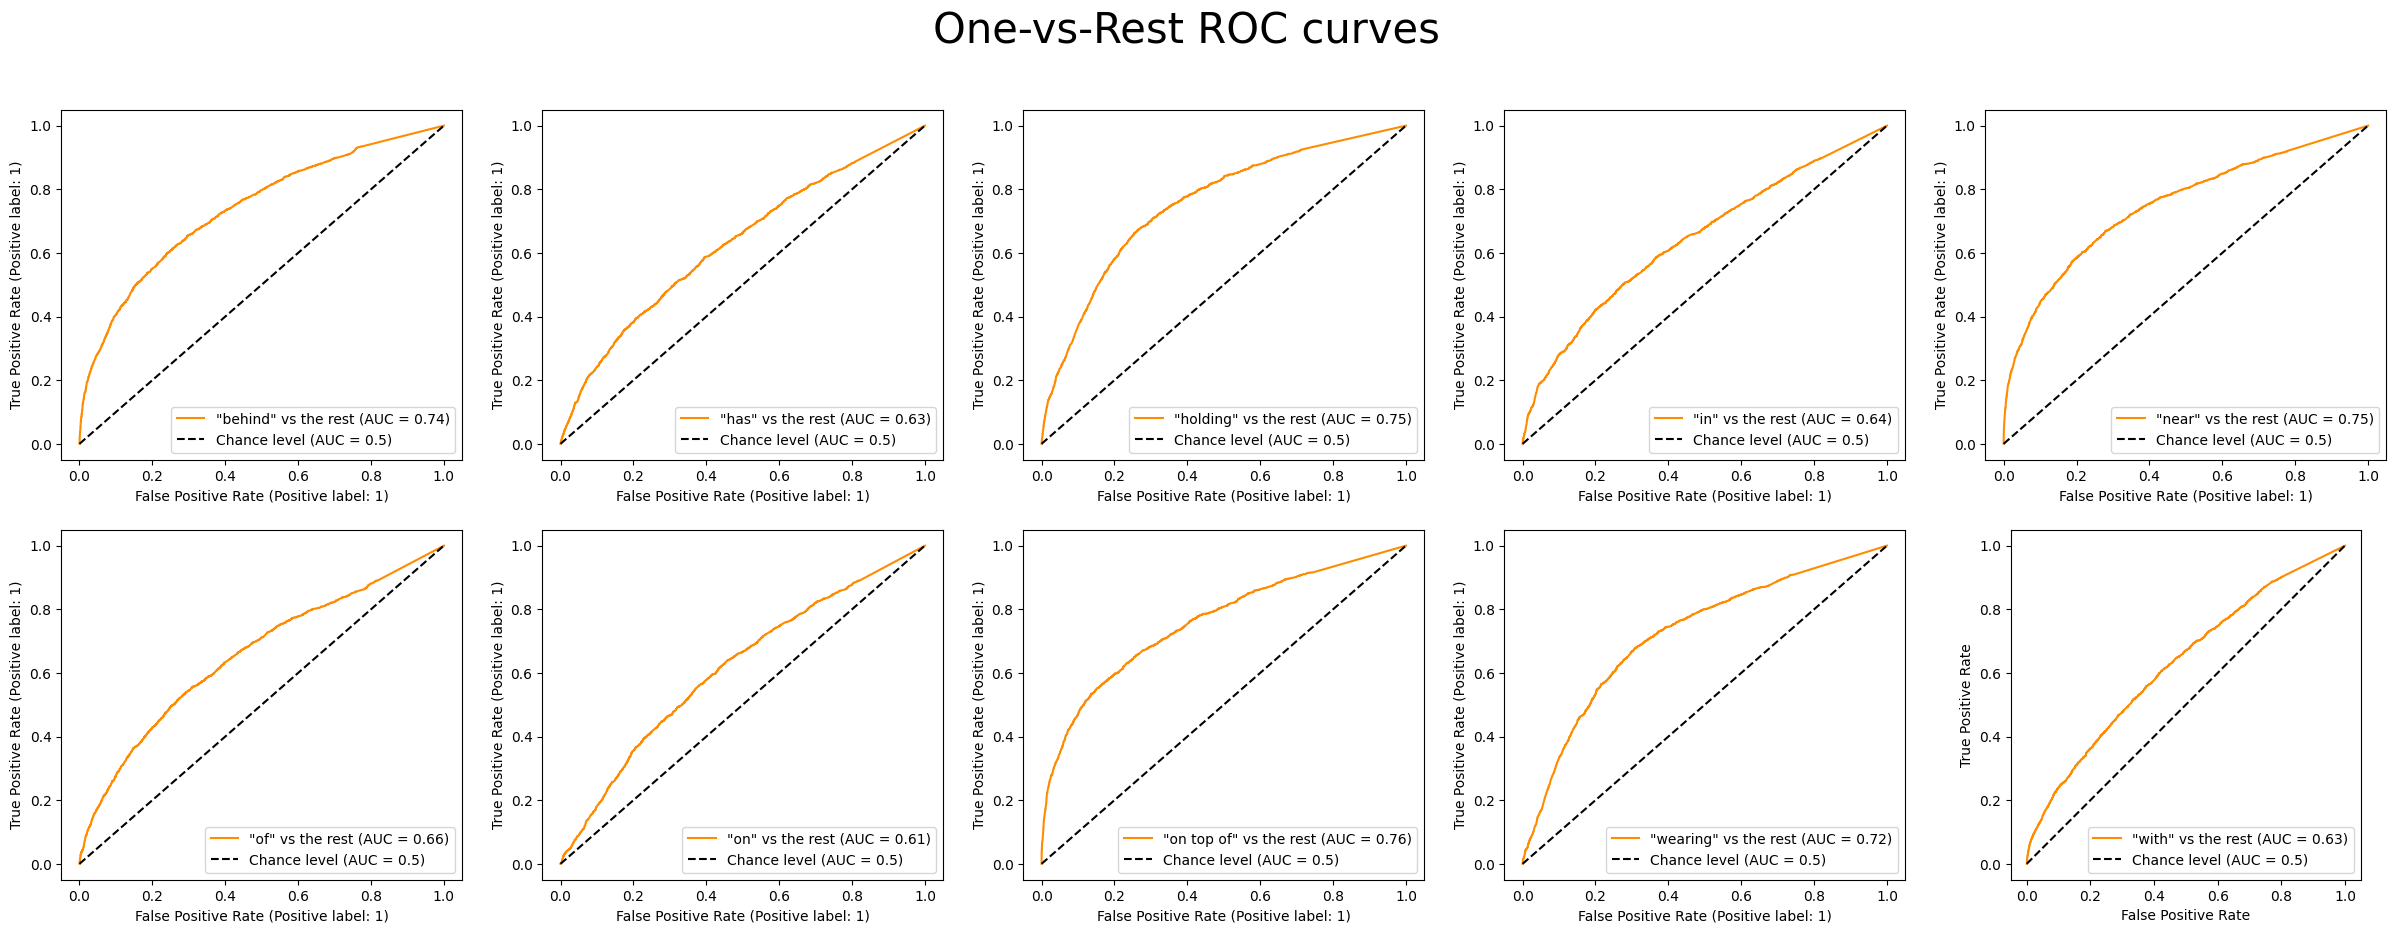

In [49]:
rf.fit(X_train_emb, y_train)
print(classification_report(y_train, rf.predict(X_train_emb)))
print(classification_report(y_test, rf.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(rf.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            rf.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            rf.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

Learning rate set to 0.095467
0:	learn: 2.2888266	total: 241ms	remaining: 4m
500:	learn: 1.7847543	total: 2m 10s	remaining: 2m 10s
999:	learn: 1.6234944	total: 4m 20s	remaining: 0us
              precision    recall  f1-score   support

      behind       0.52      0.49      0.51      3969
         has       0.49      0.44      0.46      3969
     holding       0.45      0.52      0.48      3968
          in       0.54      0.43      0.48      3968
        near       0.52      0.55      0.53      3968
          of       0.52      0.48      0.50      3969
          on       0.47      0.42      0.44      3968
   on top of       0.52      0.60      0.55      3968
     wearing       0.40      0.59      0.48      3969
        with       0.57      0.40      0.47      3968

    accuracy                           0.49     39684
   macro avg       0.50      0.49      0.49     39684
weighted avg       0.50      0.49      0.49     39684

              precision    recall  f1-score   support

    

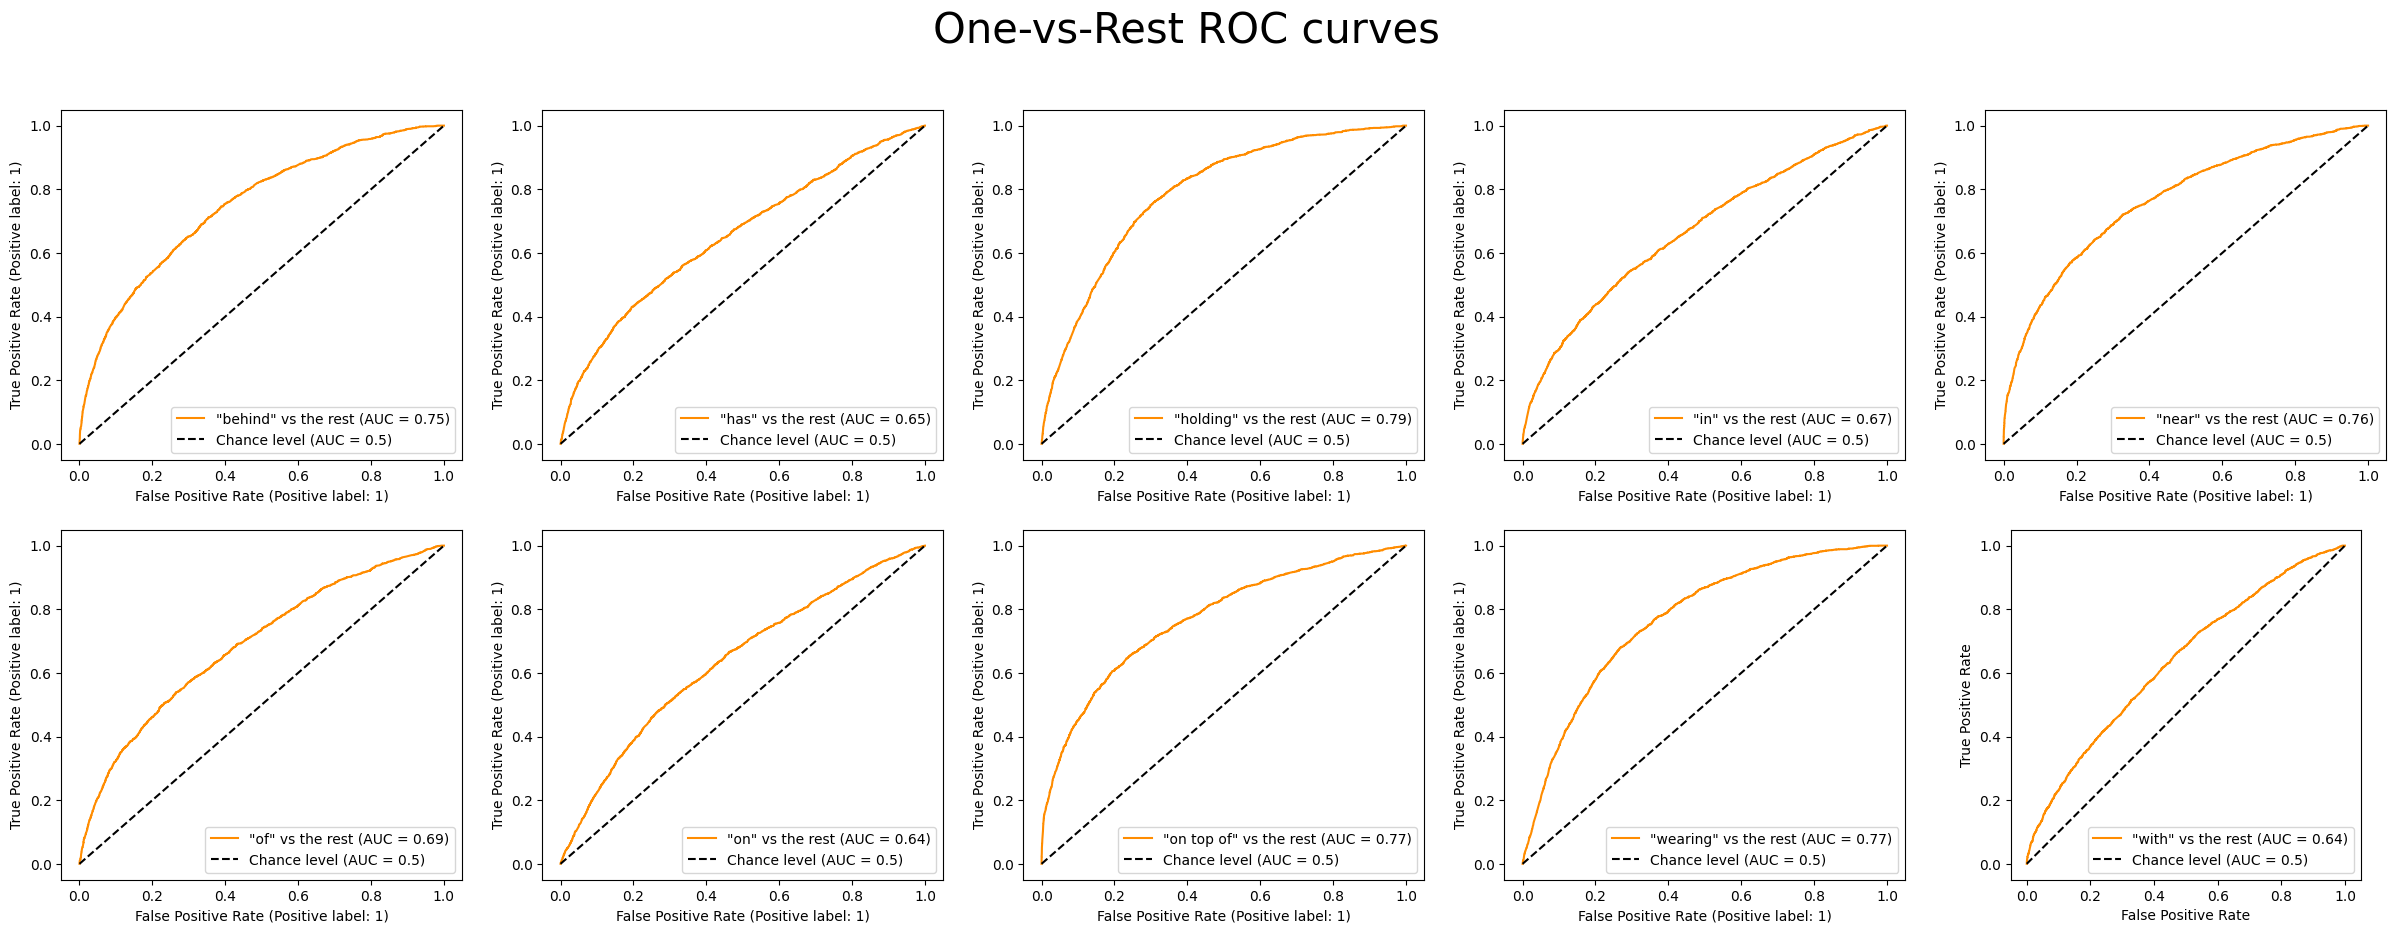

In [50]:
cb.fit(X_train_emb, y_train)
print(classification_report(y_train, cb.predict(X_train_emb)))
print(classification_report(y_test, cb.predict(X_test_emb)))

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

fig, ax = plt.subplots(2, 5, figsize = (30, 10))

for class_id, class_name in enumerate(cb.classes_):

    if class_id <= 4:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            cb.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[0][class_id]
            )
    else:
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            cb.predict_proba(X_test_emb)[:, class_id],
            name=f'"{class_name}" vs the rest',
            color="darkorange",
            plot_chance_level=True,
            ax = ax[1][class_id-5]
            )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
fig.suptitle('One-vs-Rest ROC curves', fontsize=30)
plt.legend()
plt.show()

# Выбор модели

Для сравнения моделей мы опирались в первую очередь на accuracy (в нашем случае классы сбалансированы, поэтому это самая простая и удобная метрика, которую можно было использовать) и во вторую очередь смотрели на макро-f1 (метрика тоже униваерсальная, задача не требует особого внимания к recall или, наоборот, precision)

Как можно было заметить, все метрики на тесте крайне низкие, что и ожидалось увидеть в искусственной задлаче всего с 2 признаками. 
Тем не менее по указанными выше метрикам была выбрана лучшая модель (среди моделей с одинаковыми метриками на тесте выбираллась модель с лучшей метрикой на трейне).
Таким образом, был выбран RandomForest на CountVectorizer.

Далее осуществлен подбор гиперпараметров.

# Подбор гиперпараметров

In [6]:
# объединяем train и test, так как подбор гиперпараметров будем реализовывать кросс-валидацией

X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_test], axis = 0).reset_index(drop=True)

In [7]:
# сохраняем векторайзер, обученный на всех данных
cv = fit_vec(X, CountVectorizer())

vectorizer_file = "CountVectorizer.pkl"  

with open(vectorizer_file, 'wb') as file:  
    pickle.dump(cv, file)

In [9]:
X_objects = pd.DataFrame(cv.transform(X['objects']).todense())
X_subjects = pd.DataFrame(cv.transform(X['subjects']).todense())

X_cv = pd.concat([X_objects, X_subjects], axis=1).reset_index(drop=True)
X_cv.columns = range(X_cv.columns.size)

In [10]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators':[100, 120, 150], 'criterion': ['gini', 'entropy']} 

gs = GridSearchCV(RandomForestClassifier(), params, cv=3, scoring='accuracy')

gs.fit(X_cv, y)

print(gs.best_score_)
print(gs.best_params_)

0.29238559219082444
{'criterion': 'gini', 'n_estimators': 150}


In [13]:
import pickle

# сохраняем модель
model_pkl_file = "RFClf.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(gs.best_estimator_, file)